# April through September 2020 OT-SPC Report Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
%matplotlib inline
from datetime import datetime, timedelta
from shapely.geometry import Polygon, Point
import scipy
import seaborn as sns
import shapely
import matplotlib.pyplot as plt
sns.set()

llcrnr=[14.1, -105.5]
urcrnr=[48, -64.9]
    
cent_lat = np.mean([llcrnr[0], urcrnr[0]])
cent_lon = np.mean([urcrnr[1], llcrnr[1]])

## Bring in Data and Clean it Up

#### First, start with the SPC reports, which are reported to the [Storm Prediction Center](https://www.spc.noaa.gov/climo/online/), collected and filtered by the National Centers for Environmental Information [NCEI Storm Report Archive](https://www.ncdc.noaa.gov/stormevents/) - data included in this study is January 1 2020 to August 31 2020

#### There are some caveats to this dataset - primarily
- Population bias (people send in the reports)
- Hail can be difficult to report accurately (it can melt)
- EF rating is based on DAMAGE not actual wind speed

In [2]:
# Read in location data
locations = pd.read_csv('data/StormEvents_locations-ftp_v1.0_d2020_c20210223.csv')

# Read in event details
details = pd.read_csv('data/StormEvents_details-ftp_v1.0_d2020_c20210223.csv')

In [3]:
# Use the location data to create a geodataframe, using latitude and longitude values
gdf = gpd.GeoDataFrame(locations,
                       geometry=gpd.points_from_xy(locations.LONGITUDE,
                                                   locations.LATITUDE),
                       crs="EPSG:4326")

In [4]:
# Do an attribute join based on Event ID
spc_events = gdf.merge(details, on='EVENT_ID')

In [5]:
# Add an EF rating category, which cleans up the data so the digit is not buried in string
spc_events['EF_RATING'] = spc_events.TOR_F_SCALE.str.extract('(\d+)')

### Now, we move onto the OT Data, which was derived from GOES-16 imagery - 10 April to 30 September 2020

The algorithm has already been run for this case, using a method similar to Marion et al. 2019. The minimum brightness temperature serves as the center point, as in the schematic - the steps are as follows:

1. Find an OT (pink point)
2. Extract 8 radials (red arrows) starting at middle point and find inflection points (black points) in brightness temperature field (where 2nd derivative = 0
3. Use inflection points as OT edge and create a Polygon
4. Project to equal area projection and determine area of OT

![](figures/ot_methods.png)

In [6]:
# Read in the OT data from the geojson
ot_data = gpd.read_file('data/ots_20200410_20200930.geojson').dropna(subset=['area_polygon'])

In [7]:
# Convert the OT data from polygon to point data, using the parallax corrected minimum brightness temperature point
ota_geom = [Point(xy) for xy in zip(ot_data.lon_corr, ot_data.lat_corr)]

# Add the new geometry to the geodataframe
ot_data = gpd.GeoDataFrame(ot_data, geometry=ota_geom, crs="EPSG:4326")

In [8]:
ot_data['time'] = pd.to_datetime(ot_data.time)
spc_events['BEGIN_DATE_TIME'] = pd.to_datetime(spc_events.BEGIN_DATE_TIME)

In [9]:
def convert_time(time, timezone):
    
    return time.tz_localize(zone_dict[timezone]).tz_convert('utc')

In [10]:
zone_dict = {'AST-4':'Canada/Atlantic',
             'CST-6':'US/Central',
             'EST-5':'US/Eastern',
             'MST-7':'US/Mountain',
             'PST-8':'US/Pacific',
             'AKST-9':'US/Alaska',
             'GST10':'Oman',
             'HST-10':'US/Hawaii',
             'SST-11':'US/Samoa'}

In [11]:
spc_events = spc_events[(spc_events.EVENT_TYPE == 'Hail')  | (spc_events.EVENT_TYPE == 'Tornado') | (spc_events.EVENT_TYPE == 'Thunderstorm Wind')]

In [12]:
spc_events = spc_events[spc_events.CZ_TIMEZONE != 'GST10']

In [13]:
conv_times = []
for index, row in spc_events.iterrows():
    conv_times.append(convert_time(row['BEGIN_DATE_TIME'], row['CZ_TIMEZONE']))

In [14]:
spc_events['datetime_utc'] = pd.to_datetime(conv_times)

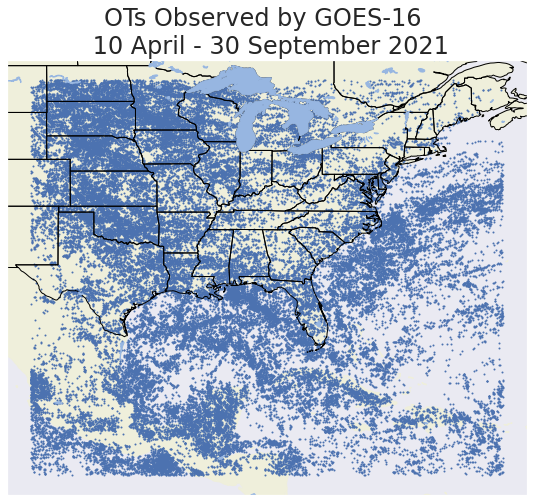

In [27]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES)

plt.scatter(ot_data.lon_corr, ot_data.lat_corr, s=1)

plt.title('OTs Observed by GOES-16 \n 10 April - 30 September 2021', fontsize=24)
#c = ot_data.plot(ax=ax, legend=True)

plt.savefig('ot_locs.png', dpi=300)

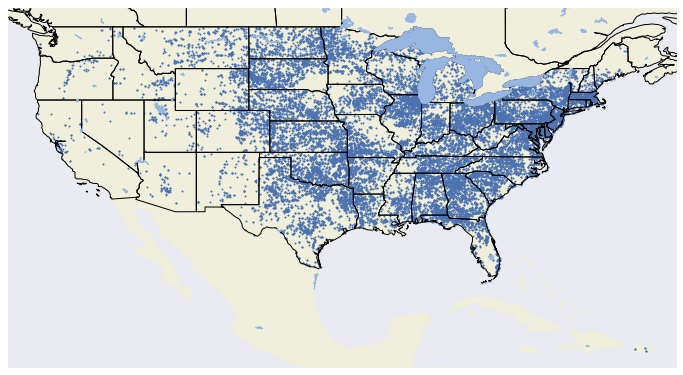

In [25]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES)

plt.scatter(spc_sub.BEGIN_LON, spc_sub.BEGIN_LAT, s=1)

In [24]:
spc_sub = spc_events[(spc_events.EVENT_TYPE == 'Hail') | (spc_events.EVENT_TYPE == 'Thunderstorm Wind') | 
                  (spc_events.EVENT_TYPE == 'Tornado')]

In [46]:
hail_sub = spc_sub[spc_sub.EVENT_TYPE == 'Hail']
wind_sub = spc_sub[spc_sub.EVENT_TYPE == 'Thunderstorm Wind']
torn_sub = spc_sub[spc_sub.EVENT_TYPE == 'Tornado']

In [47]:
hail_df = spc_events[spc_events.EVENT_TYPE == 'Hail']
wind_df = spc_events[spc_events.EVENT_TYPE == 'Thunderstorm Wind']
torn_df = spc_events[spc_events.EVENT_TYPE == 'Tornado']

In [42]:
start_date = datetime(2020, 8, 10, 14)
end_date = datetime(2020, 8, 10, 22)

ot_sub = ot_data[(ot_data.time >= start_date) & (ot_data.time <= end_date)]

wind_matches = wind_matched[(wind_matched.time >= start_date) & (wind_matched.time <= end_date)]
hail_matches = hail_matched[(hail_matched.time >= start_date) & (hail_matched.time <= end_date)]
torn_matches = torn_matched[(torn_matched.time >= start_date) & (torn_matched.time <= end_date)]

start_date = pd.to_datetime(start_date).tz_localize('utc')
end_date = pd.to_datetime(end_date).tz_localize('utc')

spc_sub = spc_events[(spc_events.datetime_utc >= start_date) & (spc_events.datetime_utc <= end_date)].dropna(subset=['MAGNITUDE'])

In [43]:
spc_sub = spc_sub.dropna(subset=['DAMAGE_PROPERTY'])

damage_property = []
for index, row in spc_sub.iterrows():
    property_total = int(float(row['DAMAGE_PROPERTY'][:-1]))
    
    damage_property.append(property_total)
    
spc_sub['damage_property'] = damage_property

In [48]:
hail_df = spc_sub[spc_sub.EVENT_TYPE == 'Hail']
wind_df = spc_sub[spc_sub.EVENT_TYPE == 'Thunderstorm Wind']
torn_df = spc_sub[spc_sub.EVENT_TYPE == 'Tornado']

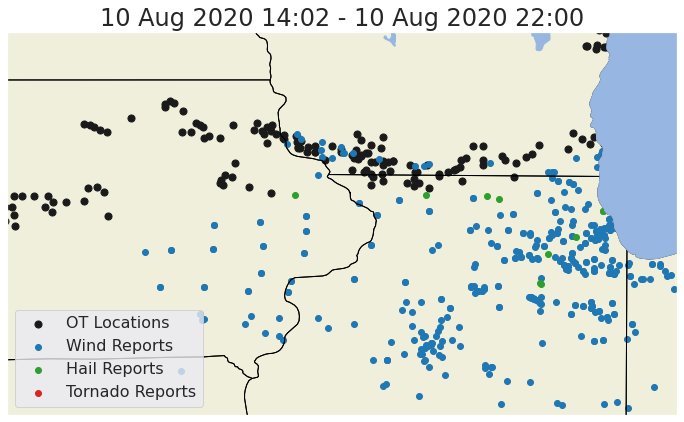

In [49]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES)

ax.scatter(ot_sub.lon_corr.values, ot_sub.lat_corr.values, s=50, color='k', label='OT Locations')

ax.scatter(wind_sub.BEGIN_LON.values, wind_sub.BEGIN_LAT.values, color='tab:blue', label='Wind Reports')
ax.scatter(hail_sub.BEGIN_LON.values, hail_sub.BEGIN_LAT.values, color='tab:green', label='Hail Reports')
ax.scatter(torn_sub.BEGIN_LON.values, torn_sub.BEGIN_LAT.values, color='tab:red', label='Tornado Reports')

ax.set_extent((-94, -87, 40, 44))

plt.legend(fontsize=16)

plt.title(pd.to_datetime(spc_sub.datetime_utc.values.min()).strftime('%d %b %Y %H:%M') + ' - ' + 
          pd.to_datetime(spc_sub.datetime_utc.values.max()).strftime('%d %b %Y %H:%M'), fontsize=24)

plt.savefig('Match_All_SPC_Reports', dpi=300)

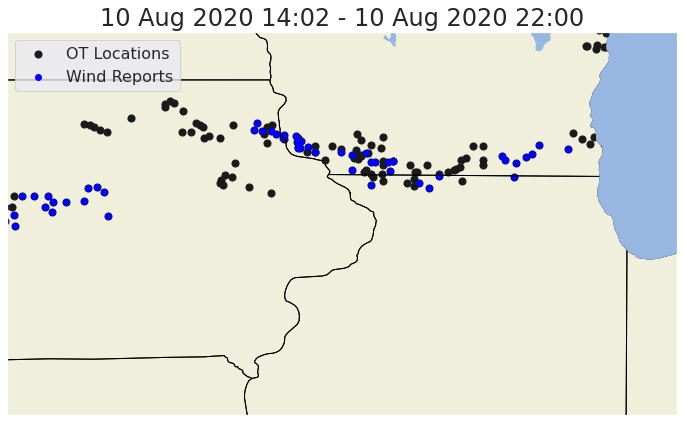

In [50]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES)

ax.scatter(ot_sub.lon_corr.values, ot_sub.lat_corr.values, s=50, color='k', label='OT Locations')

#ax.scatter(wind_matches.lon_corr.values, wind_matches.lat_corr.values, color='Blue', label='Wind Report Match')
#ax.scatter(hail_matches.lon_corr.values, hail_matches.lat_corr.values, color='Green', label='Hail Reports')
ax.scatter(wind_matches.lon_corr.values, wind_matches.lat_corr.values, color='blue', label='Wind Reports')



#c = spc_sub.plot(ax=ax, c=spc_sub.EPISODE_ID_x, legend=True)

ax.set_extent((-94, -87, 40, 44))

plt.legend(fontsize=16)

plt.title(pd.to_datetime(spc_sub.datetime_utc.values.min()).strftime('%d %b %Y %H:%M') + ' - ' + 
          pd.to_datetime(spc_sub.datetime_utc.values.max()).strftime('%d %b %Y %H:%M'), fontsize=24)

plt.savefig('wind_match.png', dpi=300)

## Now, match the OTs with SPC Damage Reports

#### The methodology used here is similar to Dworak and Bedka (2012), using the following spatiotemporal thresholds
- Within 30 minutes before/after the SPC report
- Within 60 km radius of each other

In [15]:
# Add an equal area projection using the central latitude and longitude from the dataset
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=cent_lon, central_latitude=cent_lat).proj4_params

# Project the datasets to the new coordinate reference system
ot_data_proj = ot_data.to_crs(proj)
spc_events_proj = spc_events.to_crs(proj)

In [16]:
# Create a function to match OTs with their associated hazards
def match_report(hazard_df=None, ot_df=None, hazard_type='Hail', radius=60000, time_int=30, sort_priority='MAGNITUDE',
                 ascending=False):
    """
    Matches SPC reports with OTs using a given maximum radius
    and time interval
    
    Input
    ==============
    hazard_df = pandas dataframe with spc reports (should be subset for given hazard - ex. Tornado)
    
    ot_df = pandas dataframe with OT characteristics
    
    radius = maximum radius (units of meters) to match OTs with SPC reports
    
    time_int = maximum time interval (units of minutes) to match OTs with SPC reports
    
    Output
    ==============
    matched_df = Dataframe with OT/SPC report matches
    """
    
    hazard_df = hazard_df[hazard_df.EVENT_TYPE == hazard_type]
    
    if hazard_type == 'Tornado':
        hazard_df['MAGNITUDE'] = hazard_df.EF_RATING.dropna().astype(int)
    
    hazard_df = hazard_df.dropna(subset=['MAGNITUDE'])
    
    # Add a 60 km buffer to the SPC dataset
    hazard_df['geometry'] = hazard_df.buffer(radius)
    
    # Complete a spatial join between the two
    join_df = gpd.sjoin(ot_df, hazard_df, how='inner', op='intersects')
    
    # Create new columns for datetime of SPC hazard and OT
    join_df['haz_datetime'] = pd.to_datetime(join_df.datetime_utc)
    join_df['ota_datetime'] = pd.to_datetime(join_df.time).dt.tz_localize('utc')
    
    # Find the absolute value of the time difference
    join_df['abs_time_diff'] = abs(join_df.haz_datetime - join_df.ota_datetime)
    
    # Find where the time difference is less than or equal to 30 minutes
    matched_times = join_df[abs(join_df.abs_time_diff) <= timedelta(minutes=time_int)]
    
    # Sort through values - default is to take the one with the greatest magnitude (maximum hail)
    matched_df = matched_times.sort_values(sort_priority, ascending=ascending).drop_duplicates('EVENT_ID', 
                                                                                               keep='first')
    # Grab the OT with the largest OTA to make sure there are not any duplicates
    matched_df = matched_times.sort_values('area_polygon', ascending=False).drop_duplicates(['lon_corr', 'lat_corr'],
                                                                                         keep='first')
    
    return matched_df

In [17]:
# Convert columns to datetime
ot_data_proj['time'] = pd.to_datetime(ot_data_proj.time)
spc_events_proj['BEGIN_DATE_TIME'] = pd.to_datetime(spc_events_proj.BEGIN_DATE_TIME)

In [18]:
# Add date and month columns to each dataset
ot_data_proj['day'] = ot_data_proj.sort_values('time').time.dt.day
ot_data_proj['month'] = ot_data_proj.sort_values('time').time.dt.month

spc_events_proj['day'] = spc_events_proj.sort_values('datetime_utc').datetime_utc.dt.day
spc_events_proj['month'] = spc_events_proj.sort_values('datetime_utc').datetime_utc.dt.month

In [19]:
ot_data_proj['btd'] = ot_data_proj.mintb - ot_data_proj.tropopause_temperature
ot_data_proj['ot_depth'] = ot_data_proj.cloudtop_height - ot_data_proj.tropopause_height

In [20]:
# Create lists to store dataframes
hail_list = []
wind_list = []
torn_list = []

# Iterate over each day to analyze reports to remove duplicates and maximize matches
for month in ot_data_proj.month.unique():
    ot_df = ot_data_proj[ot_data_proj.month == month]
    spc_df = spc_events_proj[spc_events_proj.month == month]
    for day in ot_df.day.unique():
        sub_ot = ot_df[ot_df.day == day]
        sub_spc = spc_df[spc_df.day == day]
        hail_list.append(match_report(sub_spc, sub_ot, hazard_type='Hail', radius=45000, time_int=35))
        wind_list.append(match_report(sub_spc, sub_ot, hazard_type='Thunderstorm Wind', radius=45000, time_int=35))
        torn_list.append(match_report(sub_spc, sub_ot, hazard_type='Tornado', radius=45000, time_int=35))

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [21]:
hail_matched = pd.concat(hail_list)
wind_matched = pd.concat(wind_list)
torn_matched = pd.concat(torn_list)

In [22]:
wind_matched.groupby('EPISODE_ID_x').count()

time  area_polygon  cloudtop_height  e_radial  e_radial_del2  \
EPISODE_ID_x                                                                 
146212           1             1                1         1              1   
146227           7             7                7         7              7   
146433          17            17               17        17             17   
146436          11            11               11        11             11   
146452           2             2                2         2              2   
...            ...           ...              ...       ...            ...   
152767          10            10               10        10             10   
152783           1             1                1         1              1   
152950           5             5                5         5              5   
153167           4             4                4         4              4   
153180           4             4                4         4              4   

              e_tb  lat  lat_corr  lon  lon_corr  ...  EPISODE_NARRATIVE  \
EPISODE_ID_x                                      ...                      
146212           1    1         1    1         1  ...                  1   
146227           7    7         7    7         7  ...                  7   
146433          17   17        17   17        17  ...                 17   
146436          11   11        11   11        11  ...                 11   
146452           2    2         2    2         2  ...                  2   
...            ...  ...       ...  ...       ...  ...                ...   
152767          10   10        10   10        10  ...                 10   
152783           1    1         1    1         1  ...                  1   
152950           5    5         5    5         5  ...                  5   
153167           4    4         4    4         4  ...                  4   
153180           4    4         4    4         4  ...                  4   

              EVENT_NARRATIVE  DATA_SOURCE  EF_RATING  datetime_utc  \
EPISODE_ID_x                                                          
146212                      1            1          0             1   
146227                      7            7          0             7   
146433                     17           17          0            17   
146436                     11           11          0            11   
146452                      2            2          0             2   
...                       ...          ...        ...           ...   
152767                      5           10          0            10   
152783                      1            1          0             1   
152950                      5            5          0             5   
153167                      4            4          0             4   
153180                      4            4          0             4   

              day_right  month_right  haz_datetime  ota_datetime  \
EPISODE_ID_x                                                       
146212                1            1             1             1   
146227                7            7             7             7   
146433               17           17            17            17   
146436               11           11            11            11   
146452                2            2             2             2   
...                 ...          ...           ...           ...   
152767               10           10            10            10   
152783                1            1             1             1   
152950                5            5             5             5   
153167                4            4             4             4   
153180                4            4             4             4   

              abs_time_diff  
EPISODE_ID_x                 
146212                    1  
146227                    7  
146433                   17  
146436                   11  
146452               

In [23]:
len(mean_wind)

NameError: name 'mean_wind' is not defined

In [24]:
len(wind_matched)

2862

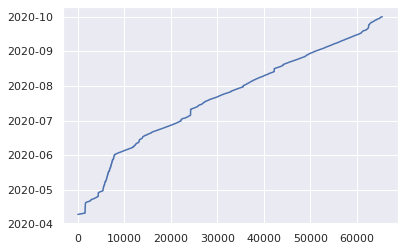

In [25]:
ot_data.time.plot()

In [26]:
start_date = datetime(2020, 4, 9, 0, 0)
end_date = datetime(2020, 10, 1, 1, 30)

ot_sub = ot_data[(ot_data.time >= start_date) & (ot_data.time <= end_date)]

wind_matches = wind_matched[(wind_matched.time >= start_date) & (wind_matched.time <= end_date)]
hail_matches = hail_matched[(hail_matched.time >= start_date) & (hail_matched.time <= end_date)]
torn_matches = torn_matched[(torn_matched.time >= start_date) & (torn_matched.time <= end_date)]

start_date = pd.to_datetime(start_date).tz_localize('utc')
end_date = pd.to_datetime(end_date).tz_localize('utc')

spc_sub = spc_events[(spc_events.datetime_utc >= start_date) & (spc_events.datetime_utc <= end_date)]

In [27]:
mean_hail = hail_matched[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth']].groupby('EPISODE_ID_x').max()

In [28]:
torn_matched['prop_damage'] = torn_matched.DAMAGE_PROPERTY.str.extract('(\d+)').fillna(0).astype(int)
good_tors = torn_matched[torn_matched.prop_damage > 0]

torn_matched = good_tors.dropna(subset=['area_polygon', 'MAGNITUDE', 'btd', 'datetime_utc'])
mean_torn = good_tors[['EPISODE_ID_y', 'MAGNITUDE', 'area_polygon', 'btd', 'TOR_WIDTH', 'ot_depth', 
                       'datetime_utc']].groupby('EPISODE_ID_y').max()

mean_torn['round_width'] = np.round(mean_torn['TOR_WIDTH'], -2)

In [29]:
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)
#mean_hail['round_damage'] = np.round(mean_hail['damage_crops'], -1)

In [34]:
from sklearn.metrics import r2_score
import numpy
import numpy as np
x = mean_hail.area_polygon
y = mean_hail.MAGNITUDE

mymodel = numpy.poly1d(np.polyfit(x, y, 3))
linmodel = numpy.poly1d(np.polyfit(x, y, 1))

r_poly = np.sqrt(r2_score(y, mymodel(x)))
r_lin = np.sqrt(r2_score(y, linmodel(x)))

print(r_poly, r_lin)

0.30280212646310906 0.2954531996254951


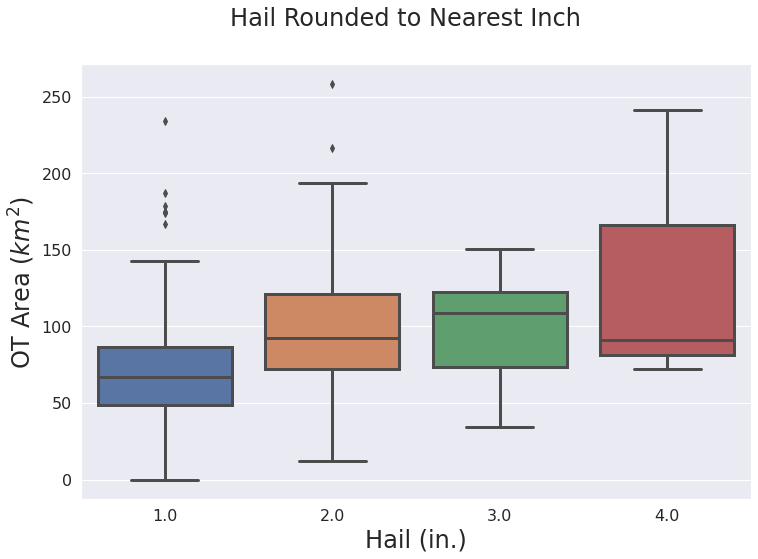

In [89]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot.png', dpi=300)

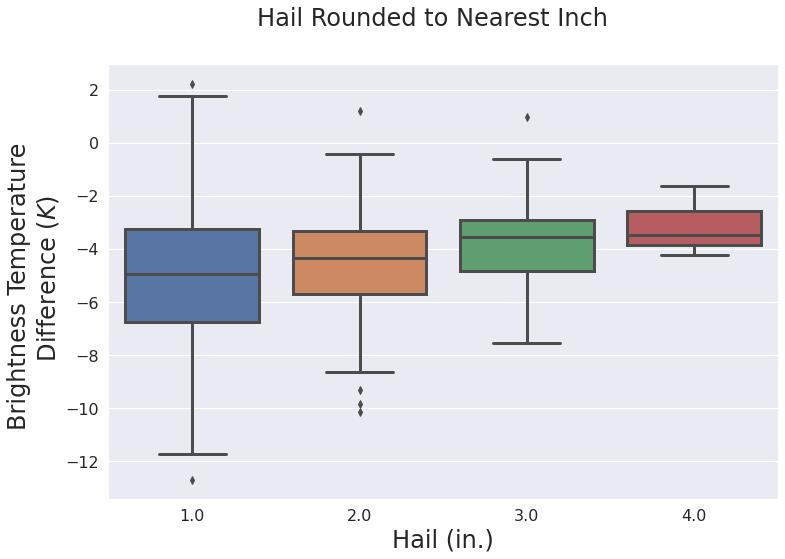

In [30]:
plt.figure(figsize=(12,8))
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)
ax = plt.subplot(111)
sns.boxplot(y='btd', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('Brightness Temperature \n Difference ($K$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot_btd.png', dpi=300)

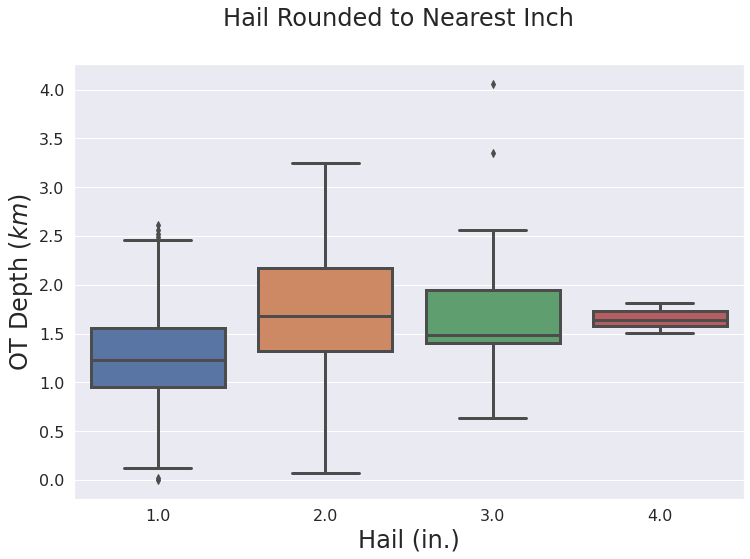

In [31]:
plt.figure(figsize=(12,8))
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)
ax = plt.subplot(111)
sns.boxplot(y='ot_depth', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('OT Depth ($km$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot_otd.png', dpi=300)
#plt.savefig('hail_boxplot_may_2017.png', dpi=300)

Text(0.5, 0.98, 'Tornado Width and OTA')

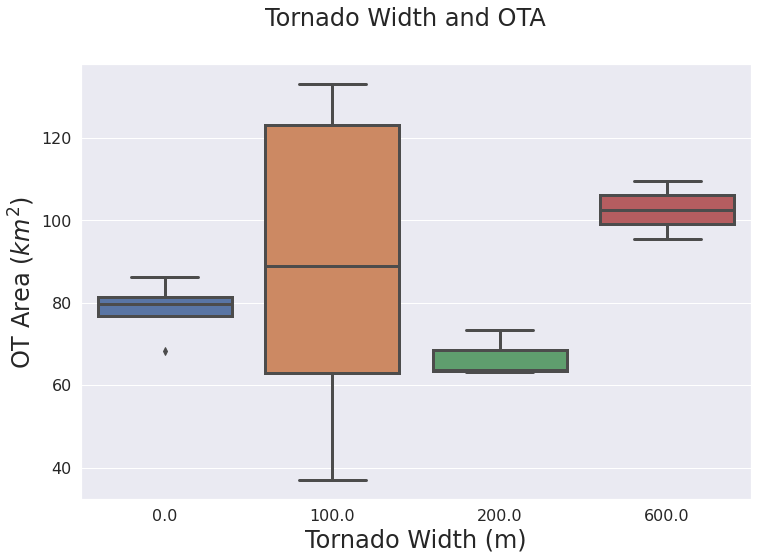

In [32]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_width',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('Tornado Width (m)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Width and OTA', fontsize=24)
#plt.savefig('tornado_width_ota.png', dpi=300)

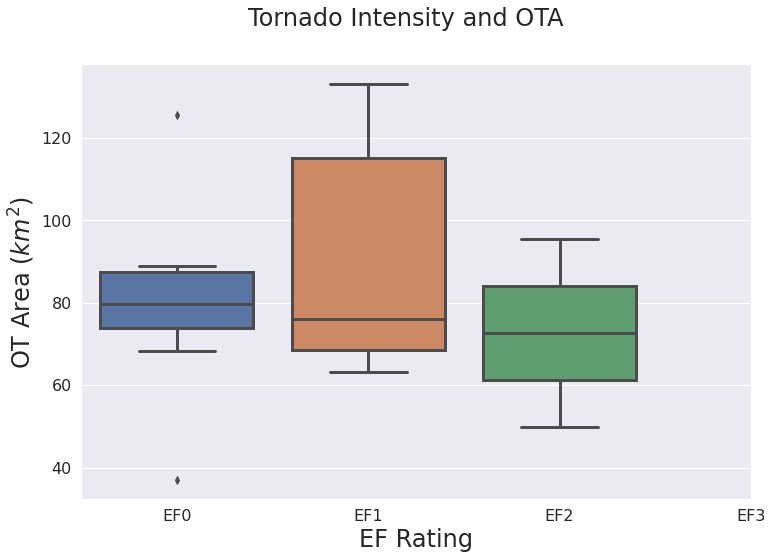

In [33]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='MAGNITUDE',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('EF Rating', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(np.arange(4), ['EF0', 'EF1', 'EF2', 'EF3'], fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Intensity and OTA', fontsize=24)
plt.savefig('tornado_intensity_ota.png', dpi=300)

In [187]:
len(mean_torn)

16

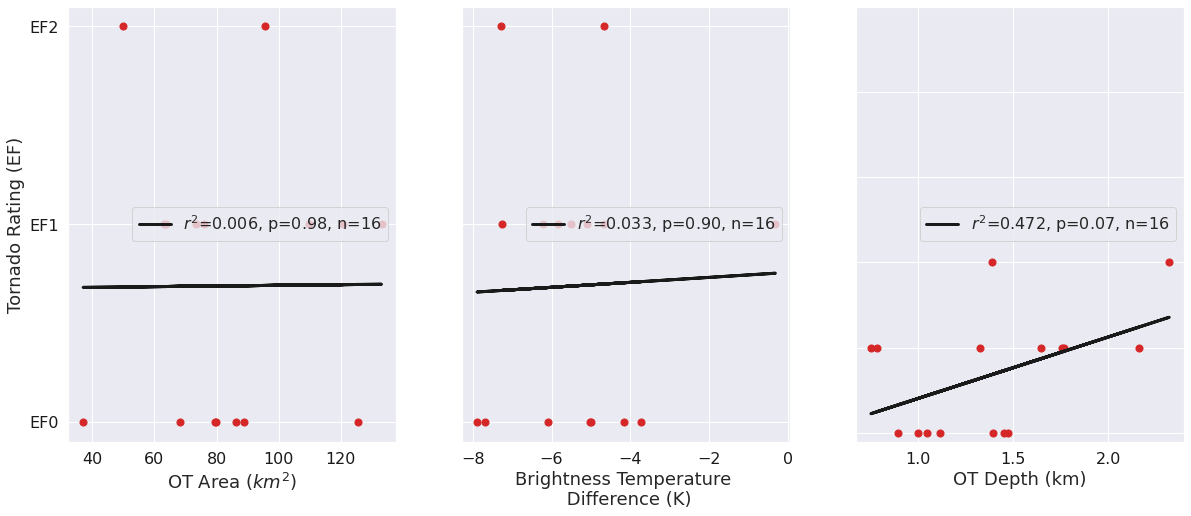

In [184]:
plot_scatter(mean_torn, 'Tornado Rating (EF)', 'area_polygon', s=50, color='tab:red', title='tornado_ot_may_2017.png')

In [61]:
mean_hail[mean_hail.MAGNITUDE < 1]['severe_hail'] = '< 1 inch'
mean_hail[mean_hail.MAGNITUDE >= 1]['severe_hail'] = '>= 1 inch'

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
len(mean_torn)

16

In [102]:
len(good_tors)

71

In [63]:
mean_tor = torn_matched[['EPISODE_ID_x', 'TOR_WIDTH', 'area_polygon', 'MAGNITUDE']].groupby('EPISODE_ID_x').mean()

---
### Now do some linear regression to see how various OT characteristics match up with the damage reports

In [64]:
def linear_regression(x, y):
    
    # Use x and y values to calculate stats
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    
    line = f'$r^{2}$={r:.3f}, p={p:.2f}, n={len(x)}'
    
    return np.array(x), intercept + slope * np.array(x), line

In [44]:
def linear_regression(x, y):
    
    # Use x and y values to calculate stats
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    
    line = f'$r^{2}$={r:.3f}, p={p:.2f}, n={len(x)}'
    
    return np.array(x), intercept + slope * np.array(x), line

def plot_scatter(df, plot_field, area_field='area_polygon', s=50, color='tab:blue', title='test.png'):
    
    # Create the plots
    fig, ax = plt.subplots(1, 3, figsize=(20,8), sharex='col', sharey='row')
    
    #if plot_field == 'TOR_WIDTH':
    #    df['MAGNITUDE'] = df['TOR_WIDTH']
        
    ax[0].scatter(df.area_polygon.values,
                  df.MAGNITUDE, s=s, color=color)
    
    # Try to run the stats for each line
    try:
        x, y, line = linear_regression(df[area_field].values, df.MAGNITUDE.values)
        ax[0].plot(x, y, label=line, color='k', linewidth=3)
        ax[0].legend(loc='right', fontsize=16)
        
    except:
        None
    
    # Compare the minimum brightness temperature and magnitude of the hazard
    ax[1].scatter(df.btd.values,
                  df.MAGNITUDE, s=s, color=color)
    
    try:
        x, y, line = linear_regression(df.btd.values, df.MAGNITUDE.values)
        ax[1].plot(x, y, label=line, color='k', linewidth=3)
        ax[1].legend(loc='right', fontsize=16)
        
    except:
        None
        
    
    # Compare the OT depth and magnitude of the hazard
    ax[2].scatter(df.ot_depth.values,
                  df.MAGNITUDE, s=s, color=color)
    
    try:
        x, y, line = linear_regression(df.ot_depth.values, df.MAGNITUDE.values)
        ax[2].plot(x, y, label=line, color='k', linewidth=3)
        ax[2].legend(loc='center right', fontsize=16)
        
    except:
        None

    for axs in ax:
        axs.tick_params(direction='out', length=6, width=2, colors='k',
                        labelsize=16)
        
    
        if plot_field == 'Tornado Rating (EF)':
            plt.yticks(np.arange(6), ['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5'], fontsize=16)
            plt.ylim(0,5)
    
    # Add some labels to the x-axes
    ax[0].set_xlabel('OT Area ($km^{2}$)', fontsize=18)
    ax[1].set_xlabel('Brightness Temperature \n Difference (K)', fontsize=18)
    ax[2].set_xlabel('OT Depth (km)', fontsize=18)

    # Add the y-axis label from user input
    ax[0].set_ylabel(plot_field, fontsize=18)
    
    plt.savefig(title, dpi=300);

#### Hail Analysis

In [80]:
mean_hail = hail_matched[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth', ]].groupby('EPISODE_ID_x').max()

In [83]:
mean_hail

MAGNITUDE  area_polygon       btd  ot_depth
EPISODE_ID_x                                             
145999             1.00      6.795673 -7.769989  1.274000
146116             1.00     83.109651 -7.250000  1.493000
146134             1.75    116.261463 -7.130005  2.091001
146227             1.00    174.741670 -6.620010  1.488000
146433             1.50     94.358271 -4.369995  1.583000
...                 ...           ...       ...       ...
152574             1.25     79.711252 -6.149994  1.097000
152767             1.00     72.870243 -2.720001  1.074000
152865             1.00    126.916412 -2.449997  0.856000
153209             1.00     40.684277 -5.350006  1.026001
153232             1.00     57.365592 -6.889999  1.272000

[282 rows x 4 columns]

In [81]:
mean_hail = mean_hail[mean_hail.MAGNITUDE >= 1]

In [82]:
mean_hail

MAGNITUDE  area_polygon       btd  ot_depth
EPISODE_ID_x                                             
145999             1.00      6.795673 -7.769989  1.274000
146116             1.00     83.109651 -7.250000  1.493000
146134             1.75    116.261463 -7.130005  2.091001
146227             1.00    174.741670 -6.620010  1.488000
146433             1.50     94.358271 -4.369995  1.583000
...                 ...           ...       ...       ...
152574             1.25     79.711252 -6.149994  1.097000
152767             1.00     72.870243 -2.720001  1.074000
152865             1.00    126.916412 -2.449997  0.856000
153209             1.00     40.684277 -5.350006  1.026001
153232             1.00     57.365592 -6.889999  1.272000

[282 rows x 4 columns]

In [48]:
hail_matched_better = hail_matched.dropna(subset=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])
hail_matched_better = hail_matched_better[hail_matched_better.MAGNITUDE >= 1]

damage_property = []
damage_crops = []
damaging_flag = []
for index, row in hail_matched_better.iterrows():
    property_total = int(float(row['DAMAGE_PROPERTY'][:-1]))
    crop_total = int(float(row['DAMAGE_CROPS'][:-1]))
    
    damage_property.append(damage_total)
    damage_crops.append(crop_total)
    
hail_matched_better['damage_property'] = damage_property
hail_matched_better['damage_crops'] = damage_crops

NameError: name 'damage_total' is not defined

In [49]:
test = wind_matched_better[(wind_matched_better.time >= datetime(2020, 8, 10, 16)) & 
                    (wind_matched_better.time <= datetime(2020, 8, 10, 22))]

NameError: name 'wind_matched_better' is not defined

In [50]:
test_groups = test.groupby('EPISODE_ID_x').max()

NameError: name 'test' is not defined

In [51]:
test_groups.index

NameError: name 'test_groups' is not defined

In [52]:
test_group1 = test[test.EPISODE_ID_x == 151777]
test_group2 = test[test.EPISODE_ID_x == 150363]
test_group3 = test[test.EPISODE_ID_x == 151778]

NameError: name 'test' is not defined

NameError: name 'test_group3' is not defined

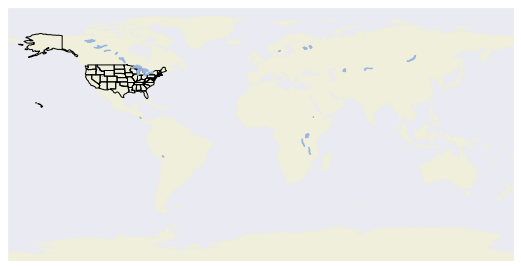

In [53]:
fig = plt.figure(figsize=(20, 8))


ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.LAKES)

#ax1.scatter(test_group1.lon_corr.values, test_group1.lat_corr.values, color='tab:red', s=test_group1.otarea_circle.values * 10)
#ax1.scatter(test_group2.lon_corr.values, test_group2.lat_corr.values, color='tab:blue', s=test_group2.otarea_circle.values * 10)
s= ax1.scatter(test_group3.lon_corr.values, test_group3.lat_corr.values, c=test_group2.otarea_circle.values, s=test_group2.otarea_circle.values * 10,
            cmap='magma')

ax1.scatter(0, 0, label=f'Max OTA: {round(test_group2.otarea_circle.values.max(),2)} $km^{2}$')

plt.colorbar(s, label='OTA ($km^{2}$)', orientation='horizontal')
plt.legend(fontsize=16)


ax1.set_extent((-94, -87, 40, 44))
plt.title('OTA from Matched Reports', fontsize=16)

ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.LAKES)

#ax2.scatter(test_group1.BEGIN_LON.values, test_group1.BEGIN_LAT.values, color='tab:red', s=test_group1.MAGNITUDE.values * 10)
#ax2.scatter(test_group2.BEGIN_LON.values, test_group2.BEGIN_LAT.values, color='tab:blue', s=test_group2.MAGNITUDE.values * 10)
s2 = ax2.scatter(test_group3.BEGIN_LON.values, test_group3.BEGIN_LAT.values, c=test_group2.MAGNITUDE.values, s=test_group2.MAGNITUDE.values * 10,
                 cmap='viridis')
ax2.scatter(0, 0, label=f'Max Wind Speed: {round(test_group2.MAGNITUDE.max(),2)} kt')
time = pd.to_datetime(test_group3.time.values[0]).strftime('%d %b %H%M UTC')
plt.suptitle(f'Matched Wind Reports from {time}', fontsize=24)
plt.colorbar(s2, label='Wind Speed (kt)', orientation='horizontal')
plt.title('Wind  from Matched Reports', fontsize=16)
ax2.set_extent((-94, -87, 40, 44))
plt.legend(fontsize=16)

plt.savefig('Example_OT_Match.png', dpi=300)

In [54]:
hail_df = spc_events[(spc_events.time > start_date) & (spc_events.MAGNITUDE > 1)]

AttributeError: 'GeoDataFrame' object has no attribute 'time'

In [55]:
len(hail_df)

NameError: name 'hail_df' is not defined

In [56]:
len(hail_matched_better)

1068

In [57]:
hail_matched_better = hail_matched[hail_matched.MAGNITUDE >= 1]

In [58]:
mean_hail = hail_matched_better[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth']].groupby('EPISODE_ID_x').max()

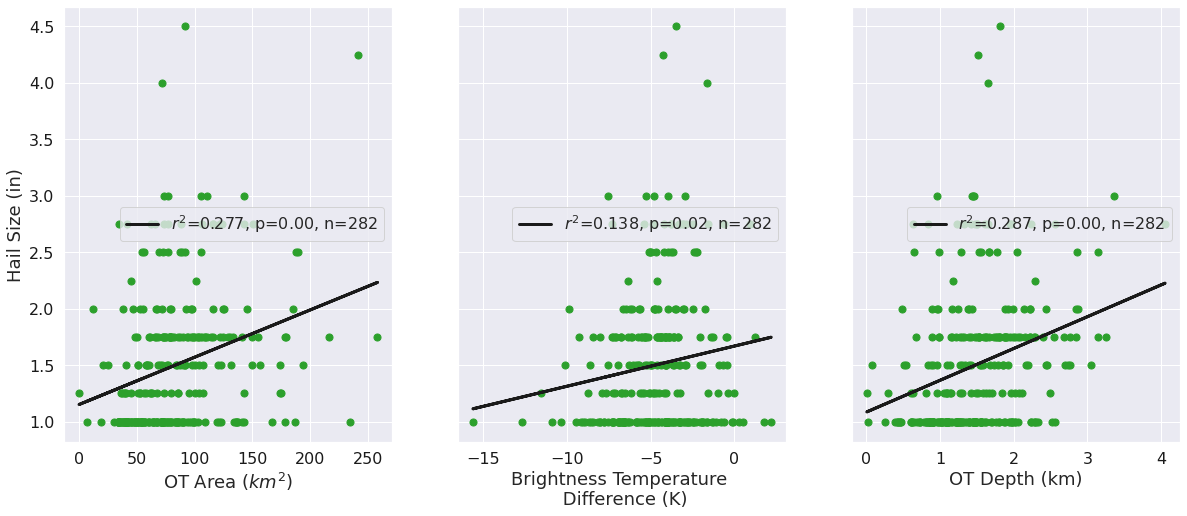

In [59]:
plot_scatter(mean_hail, 'Hail Size (in)', s=50, color='tab:green', title='Hail_OT.png')

There does not appear to be a significant relationship between OTA, minimum brightness temperature, or OT depth and hail size. The closes relationship appears to be OT depth and hail size, although the regression suggests a negative relationship such that deeper OTs have smaller hail, which would not make much physical sense since typically OT depth relates to deeper, more intense thunderstorms.

#### Wind Analysis

In [60]:
mean_wind = wind_matched[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth']].groupby('EPISODE_ID_x').max()

In [61]:
mean_wind = mean_wind[mean_wind.MAGNITUDE >= 50]

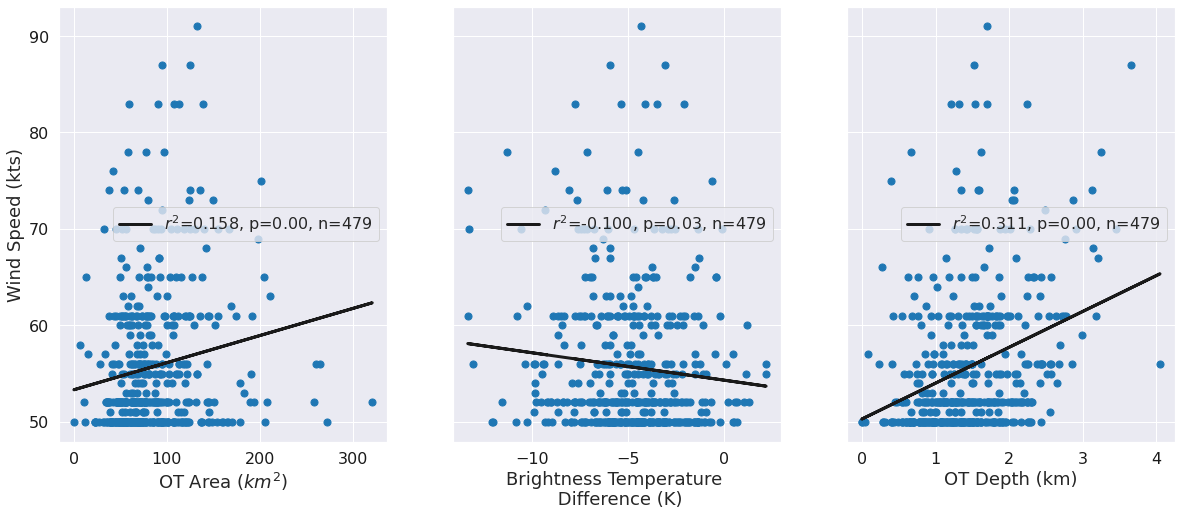

In [62]:
plot_scatter(mean_wind.dropna(subset=['area_polygon']), 'Wind Speed (kts)', s=50, color='tab:blue', title='wind_ot.png')

In [63]:
wind_matched_better = wind_matched.dropna(subset=['DAMAGE_PROPERTY'])
wind_matched_better = wind_matched_better[wind_matched_better.MAGNITUDE >= 50]

damage_totals = []
damaging_flag = []
for index, row in wind_matched_better.iterrows():
    damage_total = int(float(row['DAMAGE_PROPERTY'][:-1]))
    
    if damage_total > 0:
        damaging_flag.append('Damage')
        
    else:
        damaging_flag.append('No Damage')
    
    damage_totals.append(damage_total)
    
wind_matched_better['damage_total'] = damage_totals
wind_matched_better['damage_flag'] = damaging_flag

In [64]:
wind_matched_better['damage_total'] = damage_totals
wind_matched_better['damage_flag'] = damaging_flag

In [65]:
mean_wind = wind_matched_better[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth', 'damage_total']].groupby('EPISODE_ID_x').max()

In [66]:
mean_wind = mean_wind[mean_wind.damage_total > 0]

In [67]:
mean_wind['round_wind'] = np.round(mean_wind['MAGNITUDE'], -1)
mean_wind['round_damage'] = np.round(mean_wind['damage_total'], -2)

In [75]:
good_tors.groupby('EVENT_ID').max()

time  area_polygon  cloudtop_height   e_radial  \
EVENT_ID                                                                 
887852   2020-04-23 05:20:16     49.788314        15.903001   2.244381   
890616   2020-04-22 20:50:16    109.612339        13.891001   2.134019   
890618   2020-04-23 18:50:16     60.255211        16.285000   4.547864   
890624   2020-04-23 19:00:16     57.473803        15.224001   5.677614   
890625   2020-04-23 19:20:16     52.730244        15.090001   3.404709   
890627   2020-04-23 20:20:16     47.238198        15.981001   4.549440   
890636   2020-04-23 21:50:16     95.454835        14.944000   4.551978   
890638   2020-04-23 22:20:16     63.512126        16.318001   5.726259   
890657   2020-04-22 22:00:16     58.192053        14.347001   5.340132   
895044   2020-05-06 02:10:14    133.052225        15.086000   6.873705   
895045   2020-05-06 02:20:14    108.855466        15.471001  10.315021   
899309   2020-06-24 17:00:20     68.264418        15.936001   5.721065   
899660   2020-07-16 04:10:25     76.064815        17.464001   5.207199   
899662   2020-07-16 04:10:25     40.342778        17.042002   6.226209   
905190   2020-06-21 19:00:22     37.080277        14.339001   3.080834   
905435   2020-08-06 20:00:21    125.567065        14.666000   5.198254   
908958   2020-09-03 21:30:18     88.861989        17.050001   5.141458   
909501   2020-08-10 20:10:22     86.224567        15.046000   4.866396   
914260   2020-07-15 21:00:25     79.669614        16.431002   5.121874   
914562   2020-07-21 20:30:25    120.742835        16.352001   6.098580   
914976   2020-08-10 02:30:22     63.138785        14.396001   5.395766   
917723   2020-08-16 19:10:20     63.645192        15.418001   5.372391   
921577   2020-09-16 23:00:15     73.286351        17.111000   4.546169   
922293   2020-09-17 18:10:21     57.927327        17.585001   4.395464   
922294   2020-09-17 18:30:21     79.640596        17.157001   5.492121   

                                              e_radial_del2  \
EVENT_ID                                                      
887852    [ 0.03134155  0.02655411 -0.01381302 -0.070930...   
890616    [ 0.01722717  0.01551819 -0.00487518 -0.033515...   
890618    [ 4.06433105e-01  5.54141998e-01  5.49598694e-...   
890624    [ 0.10957336  0.13928604  0.13526535  0.106216...   
890625    [ 0.16251373  0.18667221  0.09409332 -0.106498...   
890627    [ 1.39038086e-01  1.62559509e-01  1.10893250e-...   
890636    [ 0.17891693  0.24808884  0.24687195  0.080898...   
890638    [ 0.34244537  0.42861557  0.36254501  0.149528...   
890657    [ 0.03211975  0.04621887  0.05475616  0.041900...   
895044    [ 4.43557739e-01  5.52021027e-01  4.70870972e-...   
895045    [ 0.61582947  0.76601028  0.56748199 -0.082790...   
899309    [ 0.19979095  0.26392746  0.24338913  0.061794...   
899660    [ 0.24983215  0.33726883  0.31121063  0.032993...   
899662    [ 1.69837952e-01  2.19657898e-01  2.01148987e-...   
905190    [ 0.14554596  0.14853287  0.03059387 -0.169273...   
905435    [ 2.80319214e-01  3.67752075e-01  3.52363586e-...   
908958    [ 2.19314575e-01  2.66639709e-01  1.94091797e-...   
909501    [ 0.25888824  0.2727623   0.05103302 -0.344314...   
914260    [ 0.1367569   0.17186356  0.12015533 -0.051750...   
914562    [-0.01319885 -0.03327179 -0.06521225 -0.049495...   
914976    [ 0.01819611  0.02220917  0.01774979  0.005603...   
917723    [-0.00656891  0.01740265  0.10654831  0.233322...   
921577    [ 0.20102692  0.26005173  0.23448563  0.083328...   
922293    [ 0.34511566  0.47982025  0.51411819  0.269786...   
922294    [ 0.24045563  0.31150055  0.29381561  0.139644...   

                                                       e_tb        lat  \
EVENT_ID                                                                 
887852    [199.53114319 199.82844543 200.18843079 200.52...  32.258930   
890616    [211.97789001 212.19236755 212.44129944 212.68...  36.473213   
890618    [203.09609985 203

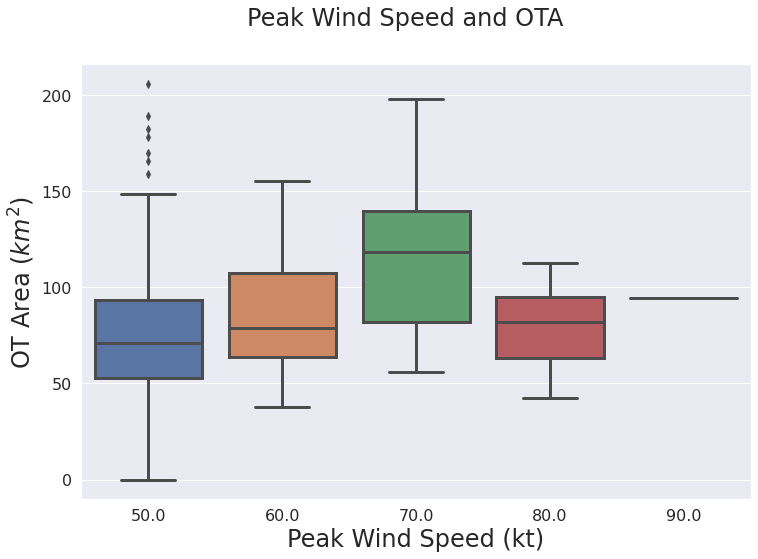

In [68]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_wind',ax=ax, linewidth=3, data=mean_wind)
plt.xlabel('Peak Wind Speed (kt)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Peak Wind Speed and OTA', fontsize=24)
plt.savefig('wind_speed_ota_box.png', dpi=300)

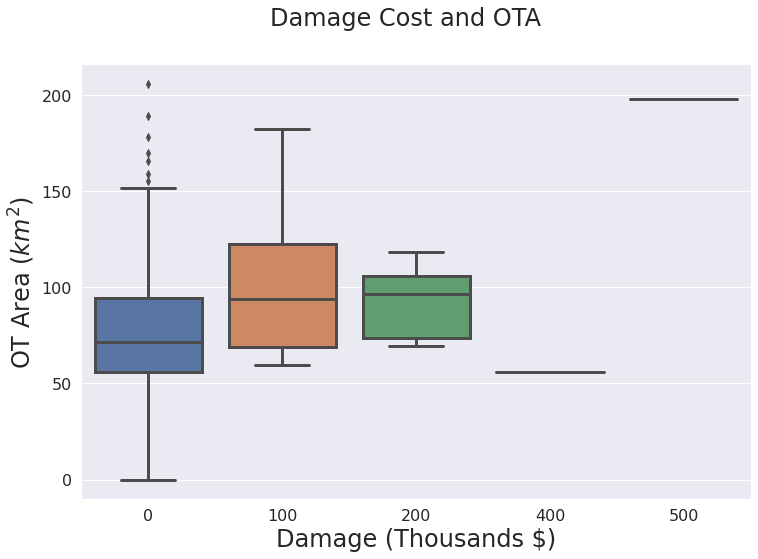

In [69]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_damage',ax=ax, linewidth=3, data=mean_wind)
plt.xlabel('Damage (Thousands $)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Damage Cost and OTA', fontsize=24)
plt.savefig('wind_damage_ota_box.png', dpi=300)

There appears to be a statistically significant relationship between minimum brightness temperature and maximum wind speed within SPC wind reports. Cooler minimum brightness temperatures (colder clouds) are related to stronger winds, which would make physical sense since previous studies show that cooler cloud top tempertaures can be related to stronger vertical wind speeds. There is not a relationship between maximum wind speed OTA or OT depth.

In [140]:
tor_df = spc_events[(spc_events.BEGIN_DATE_TIME >= datetime(2020, 4, 10)) & (spc_events.EVENT_TYPE == 'Tornado')]

In [141]:
tor_df = spc_sub[spc_sub.EVENT_TYPE == 'Tornado']

In [142]:
tor_df = tor_df.dropna(subset=['DAMAGE_PROPERTY'])

In [143]:
damage_totals = []
for index, row in tor_df.iterrows():
    damage_totals.append(int(float(row['DAMAGE_PROPERTY'][:-1])))

In [144]:
tor_df['damage_total'] = damage_totals

In [145]:
len(tor_df[tor_df.damage_total > 0])

510

In [146]:
torn_matched = torn_matched.dropna(subset =['DAMAGE_PROPERTY'])

In [147]:
damage_totals = []
for index, row in torn_matched.iterrows():
    damage_totals.append(int(float(row['DAMAGE_PROPERTY'][:-1])))

In [148]:
torn_matched['damage_amt'] = damage_totals

In [149]:
good_tors = torn_matched[torn_matched.damage_amt > 0]

In [150]:
len(torn_matched)

71

In [151]:
torn_matched = good_tors.dropna(subset=['area_polygon', 'MAGNITUDE', 'btd'])
mean_torn = good_tors[['EPISODE_ID_y', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth', 'TOR_WIDTH']].groupby('EPISODE_ID_y').max()

In [152]:
mean_torn['round_width'] = np.round(mean_torn['TOR_WIDTH'], -2)

In [153]:
mean_torn[mean_torn.round_width == 100]

MAGNITUDE  area_polygon       btd  ot_depth  TOR_WIDTH  \
EPISODE_ID_y                                                           
147470              2.0     49.788314 -7.270004  1.389000      100.0   
148570              1.0    133.052225 -0.320007  1.757000       75.0   
149262              1.0     76.064815 -7.260010  2.159000       80.0   
149498              0.0    125.567065 -6.089996  0.896999       75.0   
149578              0.0     37.080277 -7.690002  1.114000      100.0   
150772              0.0     88.861989 -5.009995  1.449000      100.0   
151820              1.0    120.742835 -5.840012  1.644000      100.0   

              round_width  
EPISODE_ID_y               
147470              100.0  
148570              100.0  
149262              100.0  
149498              100.0  
149578              100.0  
150772              100.0  
151820              100.0

In [154]:
mean_torn[mean_torn.round_width == 600]

MAGNITUDE  area_polygon       btd  ot_depth  TOR_WIDTH  \
EPISODE_ID_y                                                           
147030              1.0    109.612339 -6.220001  1.323001      600.0   
147391              2.0     95.454835 -4.659988  2.320000      600.0   

              round_width  
EPISODE_ID_y               
147030              600.0  
147391              600.0

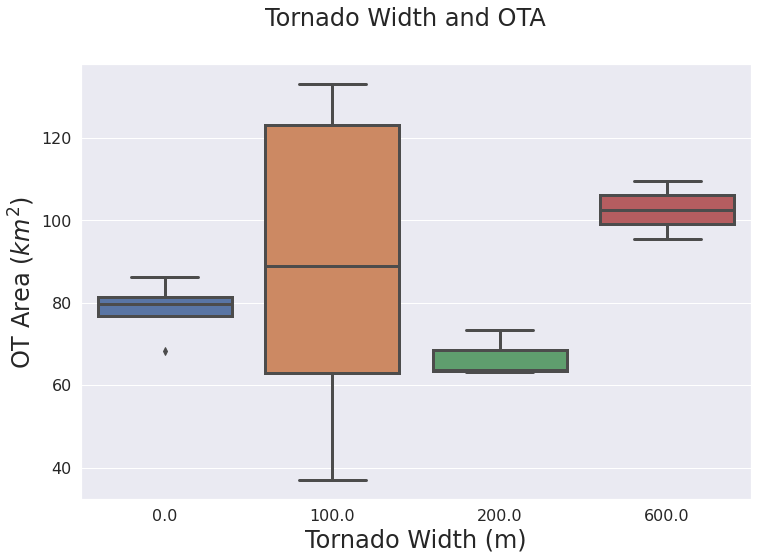

In [194]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_width',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('Tornado Width (m)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Width and OTA', fontsize=24)
plt.savefig('tornado_width_ota.png', dpi=300)

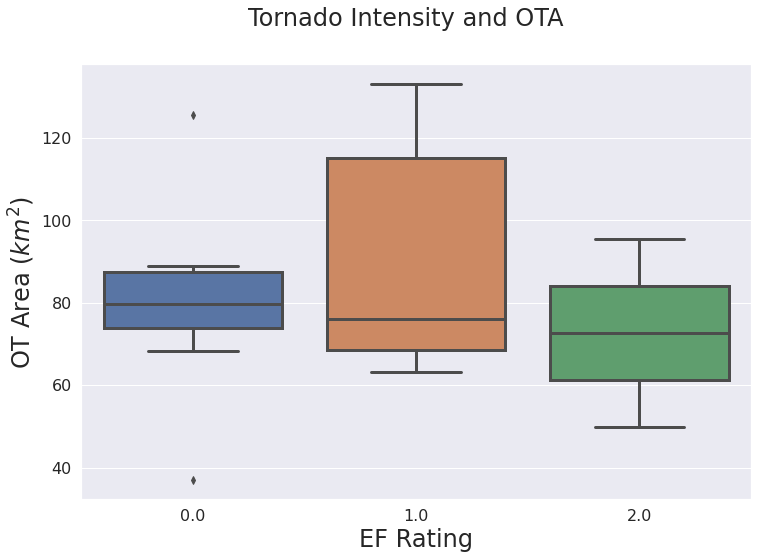

In [190]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='MAGNITUDE',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('EF Rating', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Intensity and OTA', fontsize=24)
plt.savefig('tornado_intensity_ota.png', dpi=300)

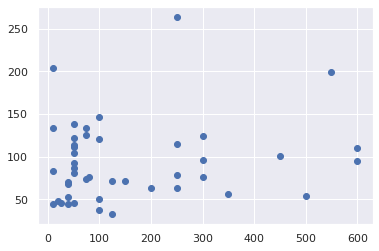

In [920]:
plt.scatter(mean_torn.TOR_WIDTH, mean_torn.area_polygon)

In [1103]:
mean_tor

MAGNITUDE  area_polygon       mintb  ot_depth
EPISODE_ID_x                                               
145999         1.000000      6.795673  208.029999  1.274000
146116         0.916667     58.294339  209.413328  1.446833
146133         0.772727     42.057688  204.244542  1.671273
146134         1.750000     89.187768  204.741661  1.529333
146227         0.934737     64.544175  211.203152  1.276158
...                 ...           ...         ...       ...
152413         2.166667     79.337420  205.919998  0.945667
152414         1.750000     53.069229  200.740904  1.241546
152424         1.000000     31.562629  205.589996  0.947001
152574         1.250000     79.711252  202.899994  1.097000
152767         1.000000     84.206579  203.264992  0.588500

[350 rows x 4 columns]

In [167]:
mean_torn

MAGNITUDE  area_polygon       btd  TOR_WIDTH  ot_depth  \
EPISODE_ID_y                                                           
147030              1.0    109.612339 -6.220001      600.0  1.323001   
147391              2.0     95.454835 -4.659988      600.0  2.320000   
147470              2.0     49.788314 -7.270004      100.0  1.389000   
148570              1.0    133.052225 -0.320007       75.0  1.757000   
149186              0.0     68.264418 -5.020004       40.0  1.045000   
149262              1.0     76.064815 -7.260010       80.0  2.159000   
149498              0.0    125.567065 -6.089996       75.0  0.896999   
149578              0.0     37.080277 -7.690002      100.0  1.114000   
149587              0.0     86.224567 -7.889999       50.0  1.474000   
150772              0.0     88.861989 -5.009995      100.0  1.449000   
151094              1.0     63.138785 -5.110001      250.0  0.752000   
151741              0.0     79.669614 -3.730011       50.0  1.000001   
151820              1.0    120.742835 -5.840012      100.0  1.644000   
152365              1.0     63.645192 -5.500000      200.0  1.768001   
153028              1.0     73.286351 -4.679993      200.0  0.782999   
153169              0.0     79.640596 -4.160004       25.0  1.396000   

                          datetime_utc  round_width  
EPISODE_ID_y                                         
147030       2020-04-22 21:26:00+00:00        600.0  
147391       2020-04-23 21:54:00+00:00        600.0  
147470       2020-04-23 05:08:00+00:00        100.0  
148570       2020-05-06 01:58:00+00:00        100.0  
149186       2020-06-24 16:27:00+00:00          0.0  
149262       2020-07-16 03:44:00+00:00        100.0  
149498       2020-08-06 19:50:00+00:00        100.0  
149578       2020-06-21 18:50:00+00:00        100.0  
149587       2020-08-10 19:38:00+00:00          0.0  
150772       2020-09-03 20:57:00+00:00        100.0  
151094       2020-08-10 01:56:00+00:00        200.0  
151741       2020-07-15 20:28:00+00:00          0.0  
151820       2020-07-21 20:05:00+00:00        100.0  
152365       2020-08-16 18:46:00+00:00        200.0  
153028       2020-09-16 22:33:00+00:00        200.0  
153169       2020-09-17 18:21:00+00:00          0.0

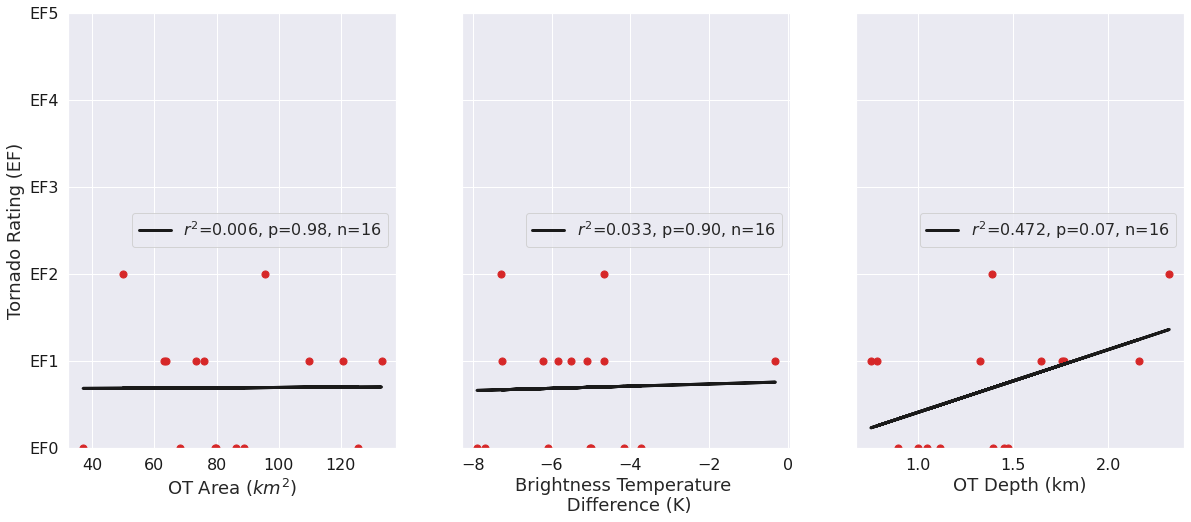

In [189]:
plot_scatter(mean_torn, 'Tornado Rating (EF)', s=50, color='tab:red', title='tornado_ot.png')

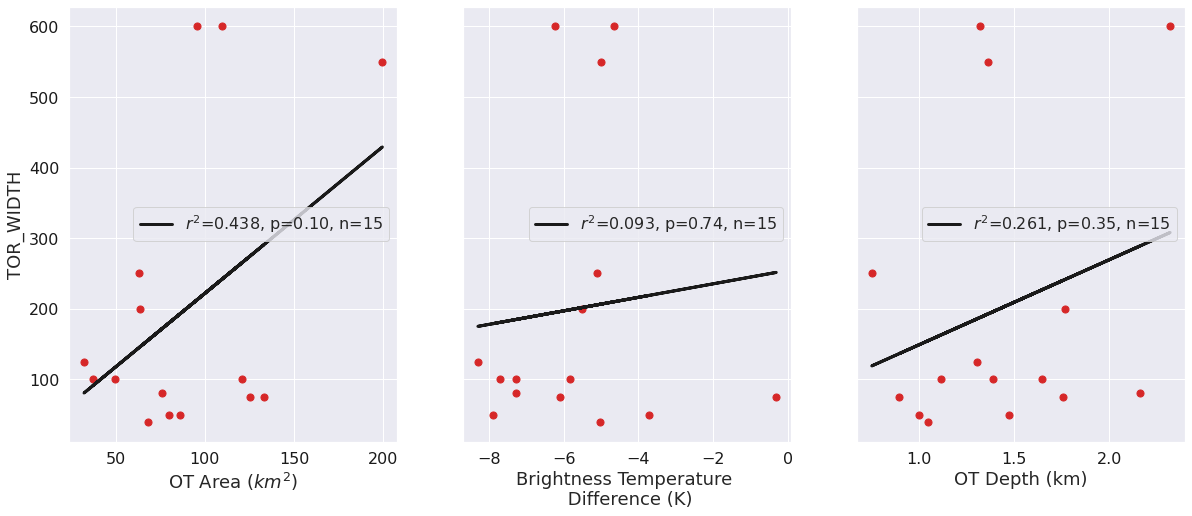

In [1183]:
plot_scatter(mean_torn, 'TOR_WIDTH', s=50, color='tab:red', title='tornado_ot.png')

In [ ]:
fig = plt.figure(figsize=(10,8))



Unfortunately, there were not enough data points with tornadoes in this case study to analyze the statistical difference with OT characteristics.

---
## Plot 5x5 degree grid boxes

As in Liu and Zipser (2005), we look at 5 x 5 degree heatmaps of OT characteristics to look at trends. The points are binned into lat/lon boxes, then averages, maxima, and counts are collected. Results are mapped to look at spatial trends.

In [94]:
def plot_boxes(min_lon=-105, max_lon=-65,
               min_lat=15, max_lat=50, deg_spacing=5.):
    
    """
    Plots grid boxes using bounds and degree spacing parameter
    """
    
    # Create lists with lon and lat values
    lon_boxes = np.arange(min_lon, max_lon, deg_spacing)
    lat_boxes = np.arange(min_lat, max_lat, deg_spacing)
    
    # Create lists to store polygon list, middle latitude, and middle longitude
    poly_list = []
    mid_lat = []
    mid_lon = []
    
    # Loop through and create lat/lon boxes every x degrees
    for lat in lat_boxes:
        for lon in lon_boxes:
            
            # Top left corner
            ullon = lon
            ullat = lat + deg_spacing
            
            # Top right corner
            urlon = lon + deg_spacing
            urlat = lat + deg_spacing

            # Bottom left corner
            lllon = lon
            lllat = lat

            # Bottom right corner
            lrlon = lon + deg_spacing
            lrlat = lat
        
            # Log the middle lat and lon values
            mid_lat.append(lat + (deg_spacing/2.))
            mid_lon.append(lon + (deg_spacing/2.))
            
            # Create a shapely polygon and append it to the list
            poly_list.append(shapely.geometry.Polygon(((ullon, ullat),
                                      (urlon, urlat),
                                      (lrlon, lrlat),
                                      (lllon, lllat))))
            
    # Return a geodataframe with polygons with middle of box lats/lons
    return gpd.GeoDataFrame({'mid_lon':mid_lon,
                             'mid_lat':mid_lat},
                              geometry=poly_list, crs="EPSG:4326")

In [95]:
start_date = datetime(2020, 4, 10,0)
start_date = pd.to_datetime(start_date).tz_localize('utc')

In [96]:
rel_spc_events = spc_events[spc_events.datetime_utc >= start_date]

In [97]:
hail_matched[hail_matched.MAGNITUDE >= 4]

time  area_polygon  cloudtop_height  e_radial  \
28572 2020-07-20 01:10:26     74.064903        14.637001  5.787165   
48890 2020-08-27 00:20:20     78.146912        15.589001  3.828216   

                                           e_radial_del2  \
28572  [ 0.14334869  0.21454239  0.27547836  0.234977...   
48890  [ 0.17086029  0.23066711  0.22599411  0.082199...   

                                                    e_tb        lat  \
28572  [205.03457642 205.25453186 205.76118469 206.55...  43.383926   
48890  [205.26055908 205.54760742 206.17637634 207.04...  43.866070   

        lat_corr        lon    lon_corr  ...  \
28572  43.195927 -105.04464 -104.907639  ...   
48890  43.670071 -101.45536 -101.330360  ...   

                                       EPISODE_NARRATIVE  \
28572  Very large hail reported with severe thunderst...   
48890  A supercell thunderstorm developed over wester...   

                                         EVENT_NARRATIVE DATA_SOURCE  \
28572                                                NaN         CSV   
48890  Very large hail broke the windshield of a law ...         CSV   

      EF_RATING              datetime_utc day_right month_right  \
28572       NaN 2020-07-20 00:45:00+00:00        20           7   
48890       NaN 2020-08-27 00:00:00+00:00        27           8   

                   haz_datetime              ota_datetime abs_time_diff  
28572 2020-07-20 00:45:00+00:00 2020-07-20 01:10:26+00:00      00:25:26  
48890 2020-08-27 00:00:00+00:00 2020-08-27 00:20:20+00:00      00:20:20  

[2 rows x 117 columns]

In [98]:
rel_spc_events.groupby('EVENT_TYPE').count()

YEARMONTH  EPISODE_ID_x  EVENT_ID  LOCATION_INDEX  \
EVENT_TYPE                                                                    
Debris Flow                     191           191       191             191   
Dust Devil                        5             5         5               5   
Flash Flood                    8380          8380      8380            8380   
Flood                          4834          4834      4834            4834   
Funnel Cloud                    220           220       220             220   
Hail                           5618          5618      5618            5618   
Heavy Rain                      908           908       908             908   
Lightning                       182           182       182             182   
Marine Hail                      11            11        11              11   
Marine High Wind                 14            14        14              14   
Marine Strong Wind                3             3         3               3   
Marine Thunderstorm Wind       1846          1846      1846            1846   
Thunderstorm Wind             14350         14350     14350           14350   
Tornado                        1337          1337      1337            1337   
Waterspout                      139           139       139             139   

                          RANGE  AZIMUTH  LOCATION  LATITUDE  LONGITUDE  \
EVENT_TYPE                                                                
Debris Flow                 191      191       191       191        191   
Dust Devil                    5        5         5         5          5   
Flash Flood                8380     8380      8380      8380       8380   
Flood                      4834     4834      4834      4834       4834   
Funnel Cloud                220      220       220       220        220   
Hail                       5618     5618      5618      5618       5618   
Heavy Rain                  908      908       908       908        908   
Lightning                   182      182       182       182        182   
Marine Hail                  11       11        11        11         11   
Marine High Wind             14       14        14        14         14   
Marine Strong Wind            3        3         3         3          3   
Marine Thunderstorm Wind   1846     1846      1846      1846       1846   
Thunderstorm Wind         14350    14350     14350     14350      14350   
Tornado                    1337     1337      1337      1337       1337   
Waterspout                  139      139       139       139        139   

                           LAT2  ...  END_LOCATION  BEGIN_LAT  BEGIN_LON  \
EVENT_TYPE                       ...                                       
Debris Flow                 191  ...           191        191        191   
Dust Devil                    5  ...             5          5          5   
Flash Flood                8380  ...          8380       8380       8380   
Flood                      4834  ...          4834       4834       4834   
Funnel Cloud                220  ...           220        220        220   
Hail                       5618  ...          5618       5618       5618   
Heavy Rain                  908  ...           908        908        908   
Lightning                   182  ...           182        182        182   
Marine Hail                  11  ...            11         11         11   
Marine High Wind             14  ...            14         14         14   
Marine Strong Wind            3  ...             3          3          3   
Marine Thunderstorm Wind   1846  ...          1846       1846       1846   
Thunderstorm Wind         14350  ...         14350      14350      14350   
Tornado                    1337  ...          1337       1337       1337   
Waterspout                  139  ...           139        139        139   

                          END_LAT  END_LON  EPISODE_NARRATIVE  \
EVENT_TYPE                                      

In [99]:
len(spc_events[(spc_events.datetime_utc > start_date) & (spc_events.EVENT_TYPE == 'Hail')])

5617

In [100]:
# Create geodataframe with 5 degree boxes
boxes = plot_boxes()

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


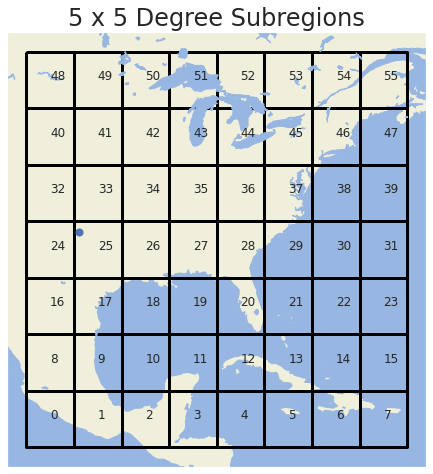

In [101]:
# Create plot and add geo axis
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Add some cartopy features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)

# Plot the polygons
gdf_regions = boxes.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=3)

# Loop through and add labels to each box
for i in range(len(boxes.index.values)):
    
    plt.text(boxes.mid_lon.values[i],
             boxes.mid_lat.values[i],
             str(boxes.index.values[i]),
             fontsize=12)

plt.scatter(-99.419650, 34.044643, s=50)
plt.title('5 x 5 Degree Subregions', fontsize=24);

#### These are the 5x5 degree boxes within the domain of this study

In [102]:
# Read in the OT data again
ot_data = gpd.read_file('data/ots_20200410_20200930.geojson')

In [103]:
ot_data = ot_data.dropna(subset=['area_polygon'])

In [104]:
# Convert the OT data from polygon to point data, using the parallax corrected minimum brightness temperature point
ota_geom = [Point(xy) for xy in zip(ot_data.lon_corr, ot_data.lat_corr)]

# Add the new geometry to the geodataframe
ot_data = gpd.GeoDataFrame(ot_data, geometry=ota_geom, crs="EPSG:4326")

In [105]:
ot_data['time'] = pd.to_datetime(ot_data.time)

In [106]:
# Set the box_index variable to store each box's index value
boxes['box_index'] = boxes.index

In [107]:
# Spatially join the OTs and lat/lon boxes
sub_regions = gpd.sjoin(ot_data, boxes, how='right')

In [108]:
sub_regions['month'] = sub_regions.time.dt.month
sub_regions['day'] = sub_regions.time.dt.day
sub_regions['hour'] = sub_regions.time.dt.hour

In [ ]:
34.044643 -99.419650
2020-05-08 00:20:14 	78.832421

In [109]:
hail_matched[hail_matched.MAGNITUDE >= 3]

time  area_polygon  cloudtop_height  e_radial  \
5833  2020-05-08 00:20:14     78.832421        15.988001  6.586952   
5830  2020-05-08 00:10:14     45.363143        14.664001  4.397308   
5836  2020-05-08 00:30:14     43.114685        15.609001  5.499032   
16027 2020-06-21 00:30:22     73.152502        13.509001  3.084084   
16624 2020-06-21 21:00:22     43.013797        15.049001  4.131079   
18722 2020-06-24 23:20:20     78.104413        14.253000  8.333426   
18716 2020-06-24 23:10:20     37.262727        14.475000  3.127246   
19323 2020-06-25 22:10:20    105.474914        14.318001  6.260703   
24721 2020-07-11 20:10:24     40.357395        16.919001  4.152719   
28572 2020-07-20 01:10:26     74.064903        14.637001  5.787165   
48890 2020-08-27 00:20:20     78.146912        15.589001  3.828216   

                                           e_radial_del2  \
5833   [ 0.29672241  0.40038681  0.44083405  0.381786...   
5830   [ 0.17149353  0.23894882  0.24906158  0.104244...   
5836   [ 3.48236084e-01  4.48810577e-01  4.16099548e-...   
16027  [ 0.17436218  0.21333694  0.13891983 -0.085189...   
16624  [ 0.28108978  0.3908577   0.40057373  0.152622...   
18722  [ 0.0604248   0.08716965  0.11168289  0.119003...   
18716  [ 0.14801788  0.17140579  0.08745193 -0.100944...   
19323  [ 0.03448486  0.05452347  0.07659912  0.074192...   
24721  [ 0.34606934  0.45185852  0.43415833  0.219947...   
28572  [ 0.14334869  0.21454239  0.27547836  0.234977...   
48890  [ 0.17086029  0.23066711  0.22599411  0.082199...   

                                                    e_tb        lat  \
5833   [198.74661255 198.59190369 199.03063965 199.88...  34.151787   
5830   [203.9979248  204.19569397 204.7364502  205.54...  34.044643   
5836   [202.01490784 201.47436523 201.6302948  202.18...  33.991074   
16027  [211.33145142 212.00418091 213.02563477 214.20...  39.205357   
16624  [203.02441406 203.77285767 205.08348083 206.83...  38.901787   
18722  [206.18257141 206.34037781 206.61903381 207.00...  38.276787   
18716  [206.26252747 206.55007935 207.13366699 207.81...  38.223213   
19323  [206.3817749  206.16294861 206.01309204 205.94...  47.651787   
24721  [200.20252991 200.21508789 200.91978455 202.04...  38.526787   
28572  [205.03457642 205.25453186 205.76118469 206.55...  43.383926   
48890  [205.26055908 205.54760742 206.17637634 207.04...  43.866070   

        lat_corr         lon    lon_corr  ...  \
5833   34.017788  -99.419650  -99.321648  ...   
5830   33.922642  -99.508934  -99.418938  ...   
5836   33.861073  -99.437500  -99.342499  ...   
16027  39.066357  -99.812500  -99.721497  ...   
16624  38.750786  -98.616070  -98.520073  ...   
18722  38.136787  -99.276790  -99.184784  ...   
18716  38.081215  -99.383934  -99.289932  ...   
19323  42.759499  -97.241070 -103.526787  ...   
24721  38.363789  -95.669650  -95.578644  ...   
28572  43.195927 -105.044640 -104.907639  ...   
48890  43.670071 -101.455360 -101.330360  ...   

                                       EPISODE_NARRATIVE  \
5833   A very intense supercell produced a long swath...   
5830   A very intense supercell produced a long swath...   
5836   A very intense supercell produced a long swath...   
16027  Although storm coverage within this portion of...   
16624  Clusters of thunderstorms moved across central...   
18722  A weak outflow boundary from morning storms se...   
18716  A weak outflow boundary from morning storms se...   
19323  Strong thunderstorm produced hail stones up to...   
24721  Supercell thunderstorms developed late morning...   
28572  Very large hail reported with severe thunderst...   
48890  A supercell thunderstorm developed over wester...   

                                         EVENT_NARRATIVE DATA_SOURCE  \
5833                                                 NaN         CSV   
5830                                                 NaN         CSV   
5836                                                 NaN         CSV   
16027  H

In [110]:
sub_regions.mid_lat.max()

47.5

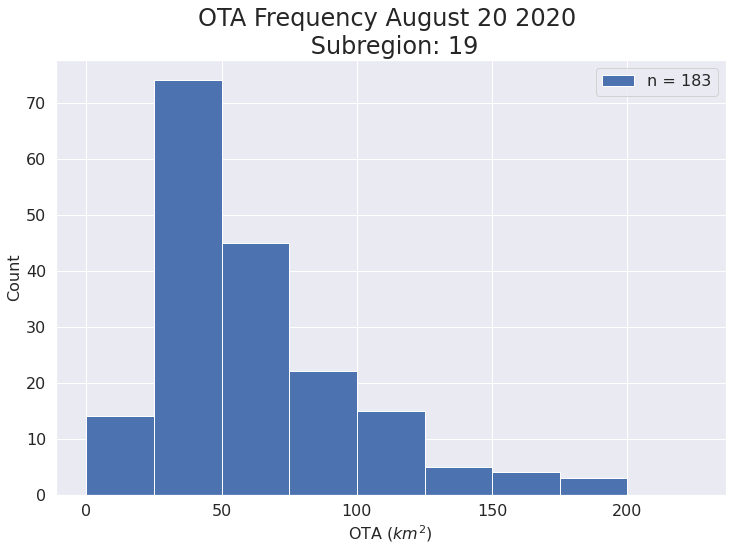

In [135]:
box_num = 19

fig = plt.figure(figsize=(12,8))
count = sub_regions[(sub_regions.month == 8) & (sub_regions.day == 20) & (sub_regions.box_index == box_num)].area_polygon
count.plot.hist(bins=np.arange(0, 250, 25), label=f'n = {len(count)}')

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.title(f'OTA Frequency August 20 2020 \n Subregion: {box_num}', fontsize=24)
plt.savefig('OT_freq_aug_20.png', dpi=300)

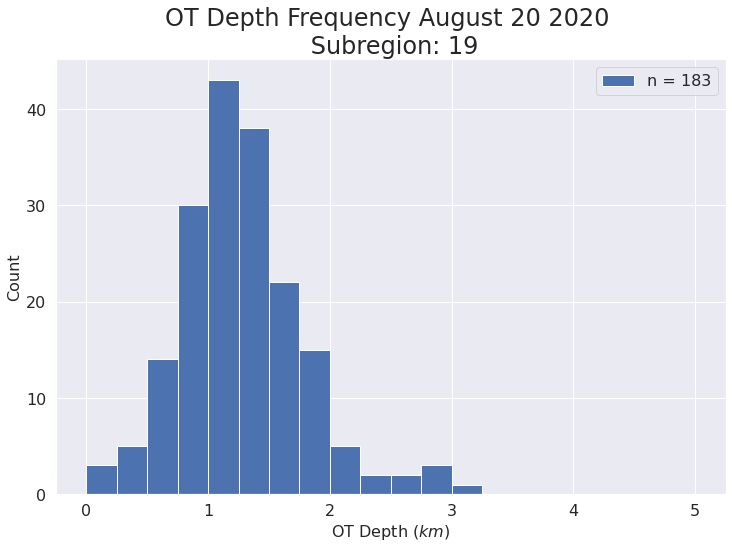

In [136]:
box_num = 19

fig = plt.figure(figsize=(12,8))
count = sub_regions[(sub_regions.month == 8) & (sub_regions.day == 20) & (sub_regions.box_index == box_num)].ot_depth
count.plot.hist(bins=np.arange(0, 5.25, .25), label=f'n = {len(count)}')

plt.xlabel('OT Depth ($km$)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.title(f'OT Depth Frequency August 20 2020 \n Subregion: {box_num}', fontsize=24)
plt.savefig('OT_depth_freq_aug_20.png', dpi=300)

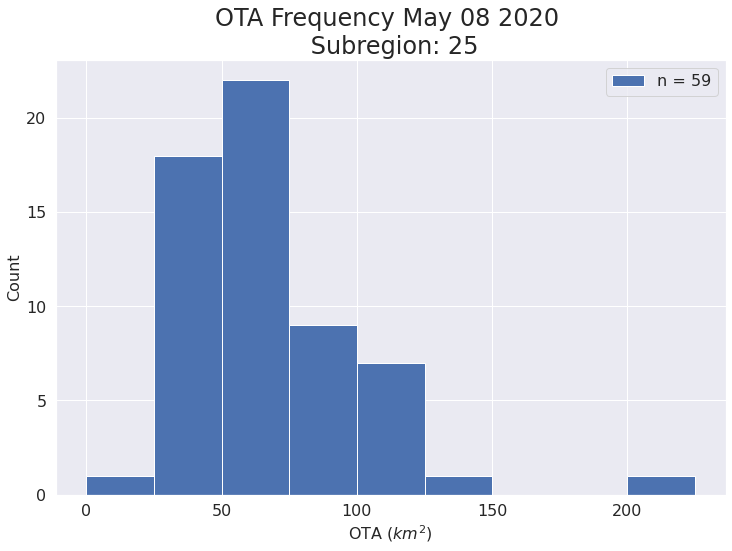

In [137]:
box_num = 25

fig = plt.figure(figsize=(12,8))
sub = sub_regions[(sub_regions.month == 5) & (sub_regions.day == 8) & (sub_regions.box_index == box_num)]
count = sub.area_polygon
count.plot.hist(bins=np.arange(0, 250, 25), label=f'n = {len(count)}')

plt.xlabel('OTA ($km^2$)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

time = pd.to_datetime(sub.time.values[10]).strftime('%b %d %Y')

plt.title(f'OTA Frequency {time} \n Subregion: {box_num}', fontsize=24)
plt.savefig('OT_freq_may_08.png', dpi=300)

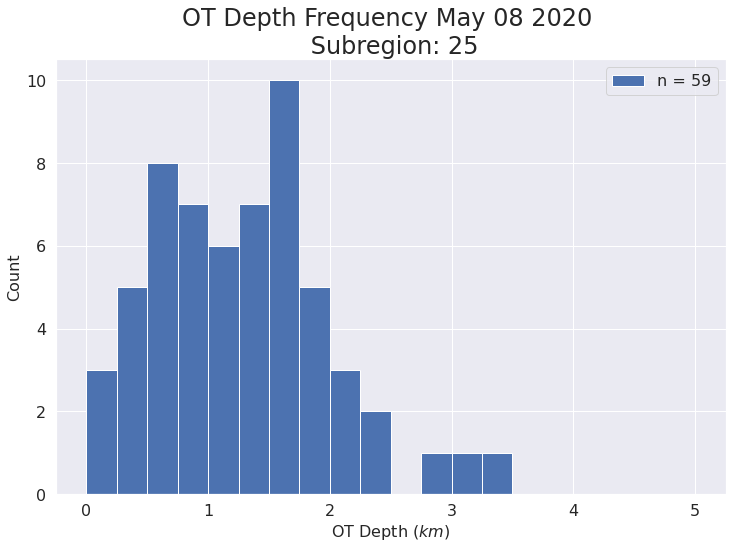

In [138]:
box_num = 25

fig = plt.figure(figsize=(12,8))
sub = sub_regions[(sub_regions.month == 5) & (sub_regions.day == 8) & (sub_regions.box_index == box_num)]
count = sub.ot_depth
count.plot.hist(bins=np.arange(0, 5.25, .25), label=f'n = {len(count)}')

plt.xlabel('OT Depth ($km$)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.title(f'OT Depth Frequency {time} \n Subregion: {box_num}', fontsize=24)
plt.savefig('OT_depth_freq_may_08.png', dpi=300)

In [115]:
# Add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

NameError: name 'sigma' is not defined

In [117]:
def plot_frequency(df, label=''):
    
    # Dissolve OTs within the boxes using mean, median, and counts
    avg_boxes = df.dissolve(aggfunc='mean', by='box_index')
    med_boxes = df.dissolve(aggfunc='median', by='box_index')
    count_boxes = df.dissolve(aggfunc='count', by='box_index')
    
    # Determine frequency of OTs by weighting by total number
    count_boxes['freq'] = count_boxes['area_polygon'] / count_boxes.area_polygon.sum()
    print(count_boxes.area_polygon.sum())
    avg_boxes['area_weighted'] = avg_boxes['area_polygon'] / count_boxes.area_polygon.sum()
    
    # Plot OT frequency
    fig = plt.figure(figsize=(12,8))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())

    # Plot OT frequency, using Red colormap
    count_boxes.plot(ax=ax, column='freq', legend=True, cmap='Reds')

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)

    plt.title(f'OT Frequency \n {label}', fontsize=24)
    plt.savefig(f'OT_Freq_{label}.png', dpi=200)
    plt.close()
    ##############################
    fig = plt.figure(figsize=(12,8))

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    avg_boxes.plot(ax=ax, column='area_polygon', legend=True, cmap='Reds', vmin=50, vmax=100)

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)

    plt.title(f'Average OTA ($km^{2}$) \n {label}', fontsize=24)
    #plt.savefig(f'OTA_Avg_{label}.png', dpi=200)
    plt.show()
    plt.close();

3946


/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


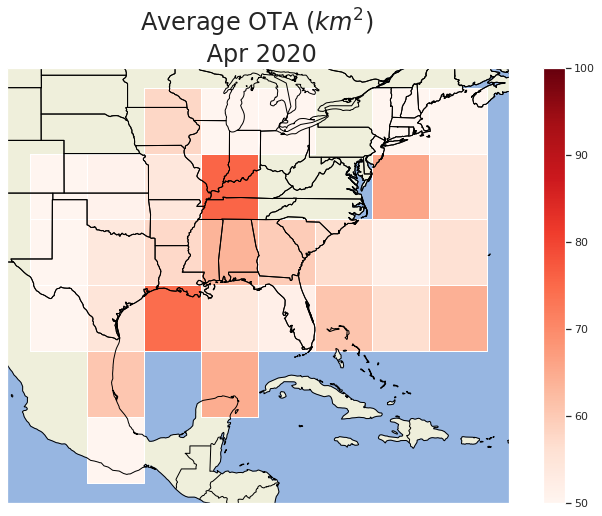

2427


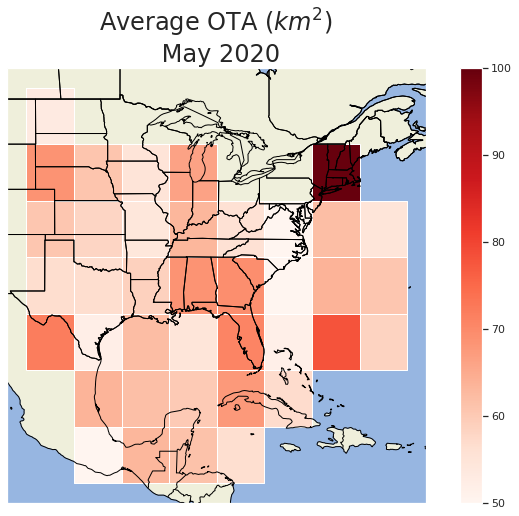

13985


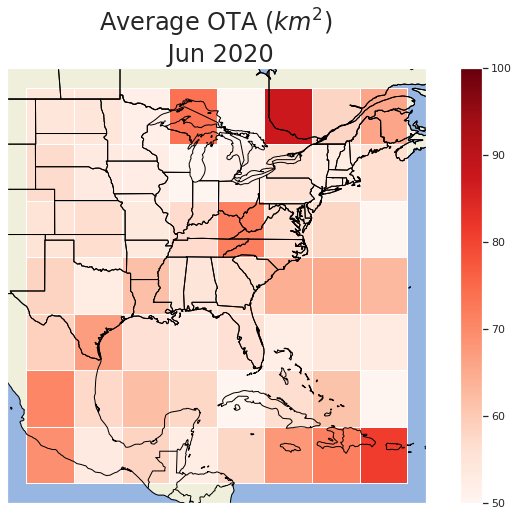

13091


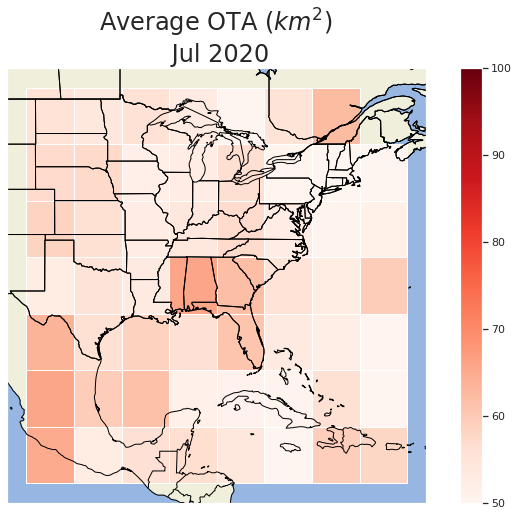

15202


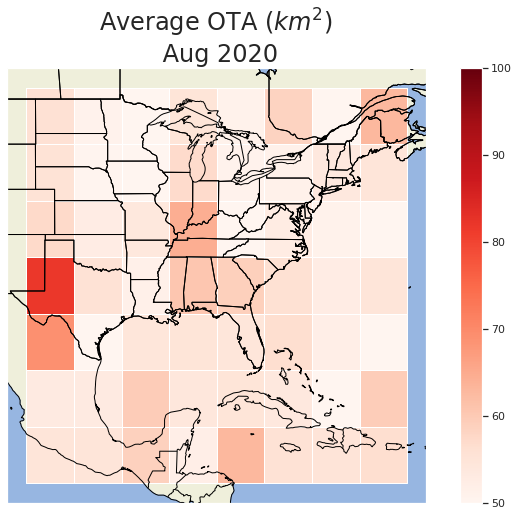

13313


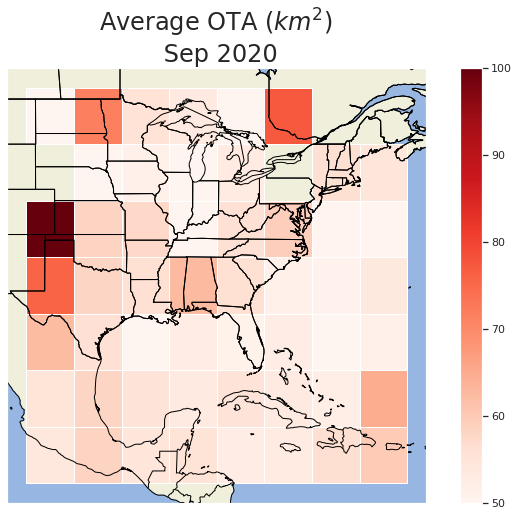

In [118]:
for i in np.unique(sub_regions.month):
    month_ab = pd.to_datetime(datetime(2020, i, 1, 0)).strftime('%b')
    
    plot_frequency(sub_regions[sub_regions.month == i], month_ab + ' 2020')

In [806]:
for i in np.unique(sub_regions.hour):
    
    plot_frequency(sub_regions[sub_regions.hour == i], str(i) + ' UTC 2020')

61964


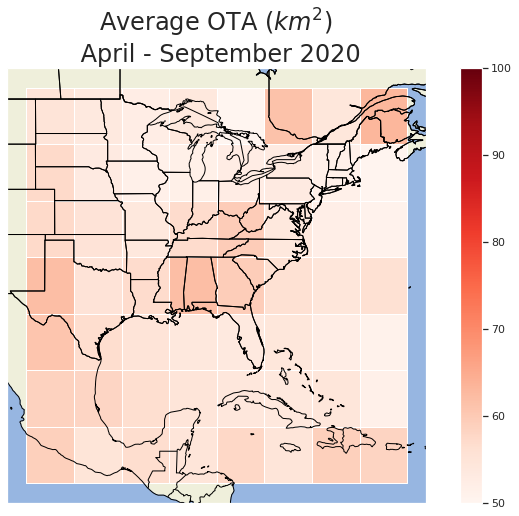

In [119]:
plot_frequency(sub_regions, 'April - September 2020')

In [121]:
# Dissolve OTs within the boxes using mean, median, and counts
avg_boxes = sub_regions.dissolve(aggfunc='mean', by='box_index')
med_boxes = sub_regions.dissolve(aggfunc='median', by='box_index')
count_boxes = sub_regions.dissolve(aggfunc='count', by='box_index')

In [122]:
mean_ota = sub_regions[(sub_regions.box_index == box_num)].groupby('hour').mean().area_polygon

In [123]:
count_ots = sub_regions[(sub_regions.box_index == box_num)].groupby('hour').count().area_polygon

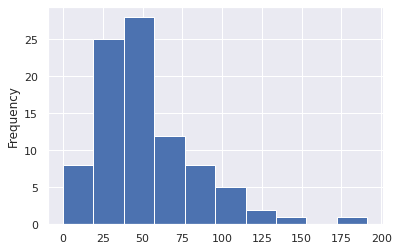

In [124]:
sub_regions[(sub_regions.time >= datetime(2020, 8, 10, 12)) & (sub_regions.time <= datetime(2020, 8, 10, 15))].area_polygon.plot.hist()

Text(0.5, 1.0, 'Hourly Distribution OTs \n Subregion: 2')

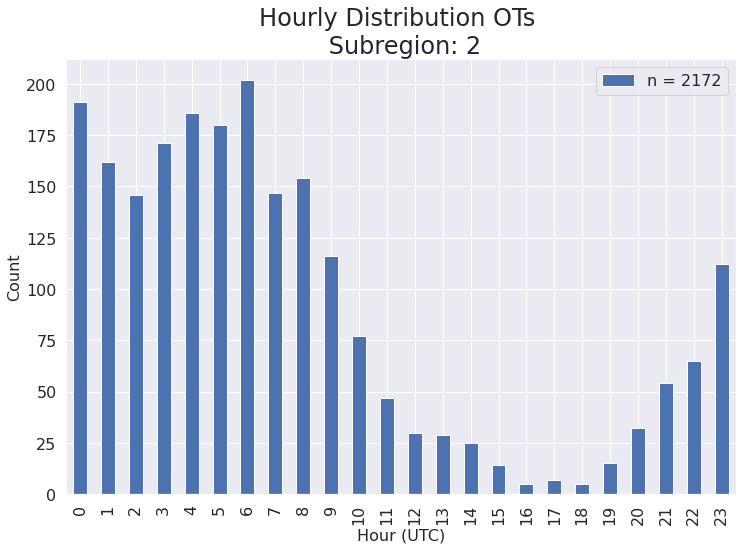

In [897]:
box_num = 2

fig = plt.figure(figsize=(12,8))
count = sub_regions[(sub_regions.box_index == box_num)].groupby('hour').count().area_polygon
count.plot.bar(label=f'n = {sum(count)}')

plt.xlabel('Hour (UTC)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.title(f'Hourly Distribution OTs \n Subregion: {box_num}', fontsize=24)

Text(0.5, 1.0, 'Hourly Distribution Max Area OTs')

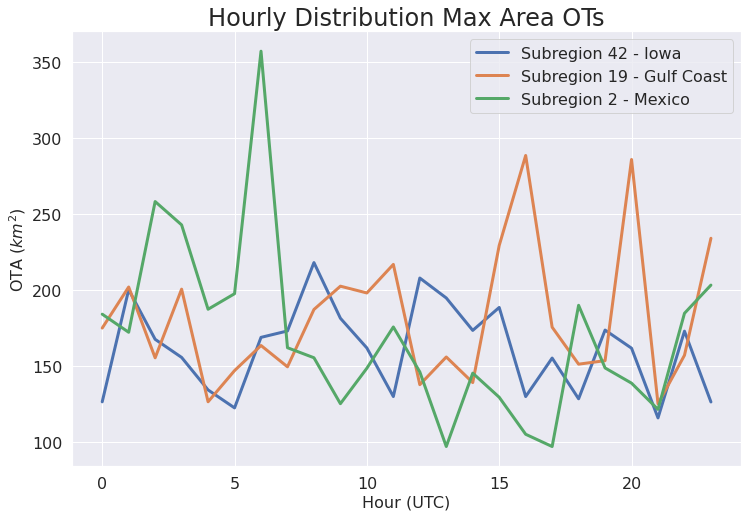

In [914]:
sub1 = 42
sub2 = 19
sub3= 2

fig = plt.figure(figsize=(12,8))
sub_regions[(sub_regions.box_index == sub1)].groupby('hour').max().area_polygon.plot(linewidth=3, label=f'Subregion {sub1} - Iowa')
sub_regions[(sub_regions.box_index == sub2)].groupby('hour').max().area_polygon.plot(linewidth=3, label=f'Subregion {sub2} - Gulf Coast')
sub_regions[(sub_regions.box_index == sub3)].groupby('hour').max().area_polygon.plot(linewidth=3, label=f'Subregion {sub3} - Mexico')

plt.xlabel('Hour (UTC)', fontsize=16)
plt.ylabel('OTA ($km^{2}$)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, loc='upper right')

plt.title(f'Hourly Distribution Max Area OTs', fontsize=24)

Text(0.5, 1.0, 'Hourly Distribution OT Frequency')

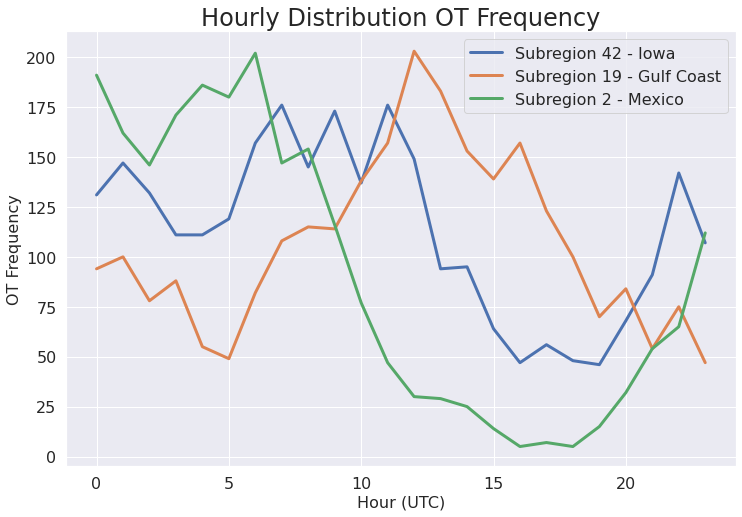

In [911]:
sub1 = 42
sub2 = 19
sub3= 2

fig = plt.figure(figsize=(12,8))
sub_regions[(sub_regions.box_index == sub1)].groupby('hour').count().area_polygon.plot(linewidth=3, label=f'Subregion {sub1} - Iowa')
sub_regions[(sub_regions.box_index == sub2)].groupby('hour').count().area_polygon.plot(linewidth=3, label=f'Subregion {sub2} - Gulf Coast')
sub_regions[(sub_regions.box_index == sub3)].groupby('hour').count().area_polygon.plot(linewidth=3, label=f'Subregion {sub3} - Mexico')

plt.xlabel('Hour (UTC)', fontsize=16)
plt.ylabel('OT Frequency', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16, loc='upper right')

plt.title(f'Hourly Distribution OT Frequency', fontsize=24)

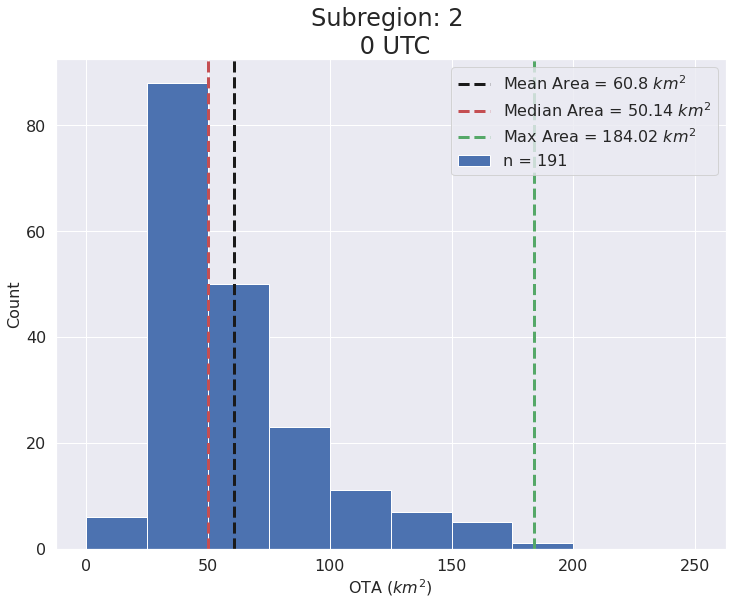

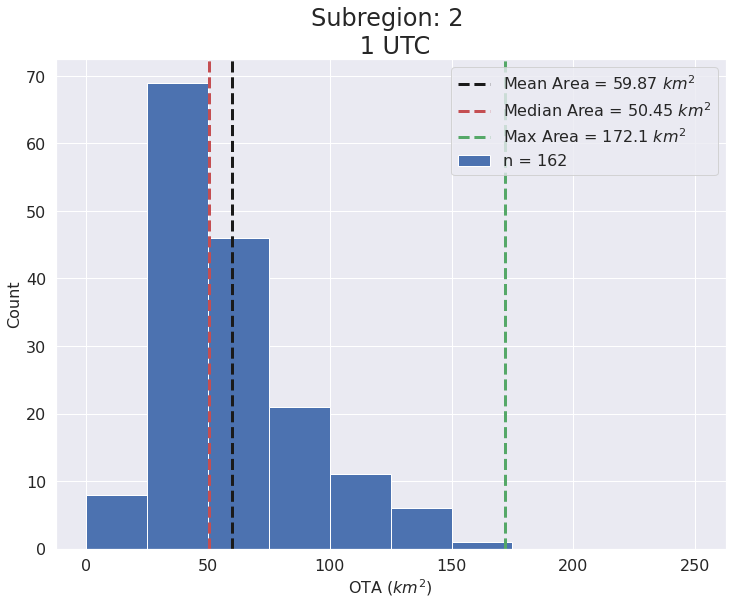

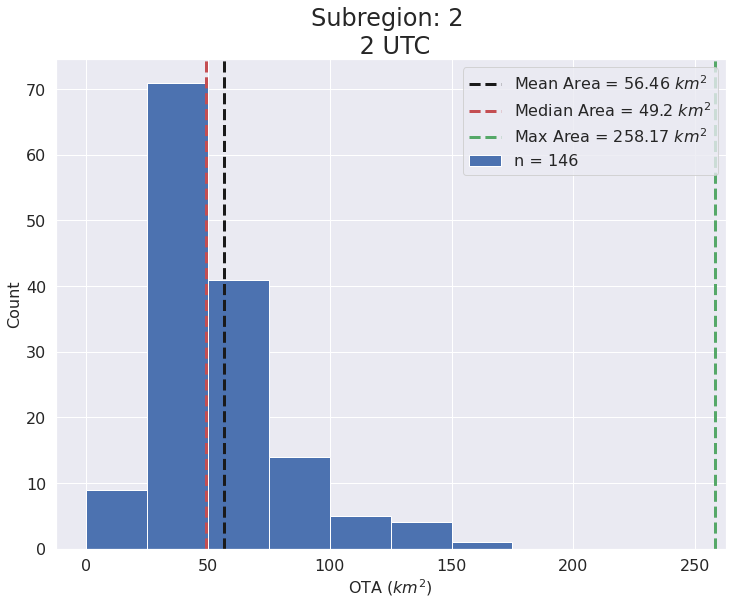

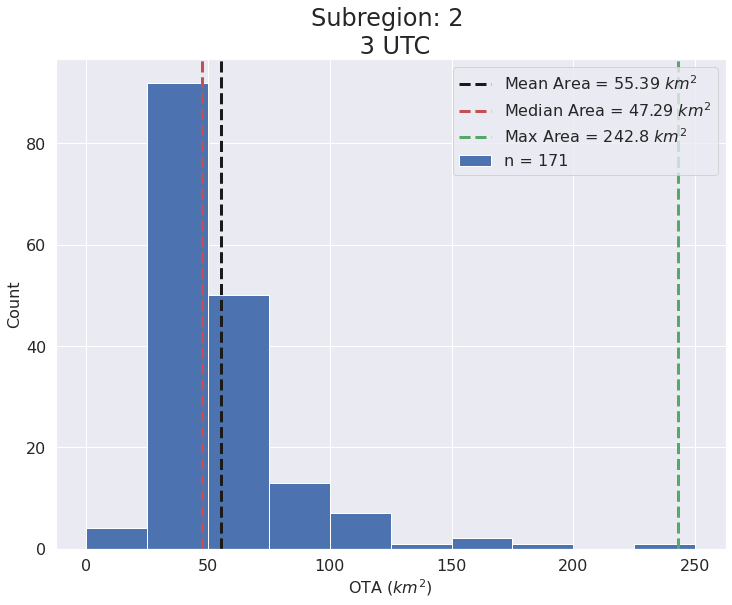

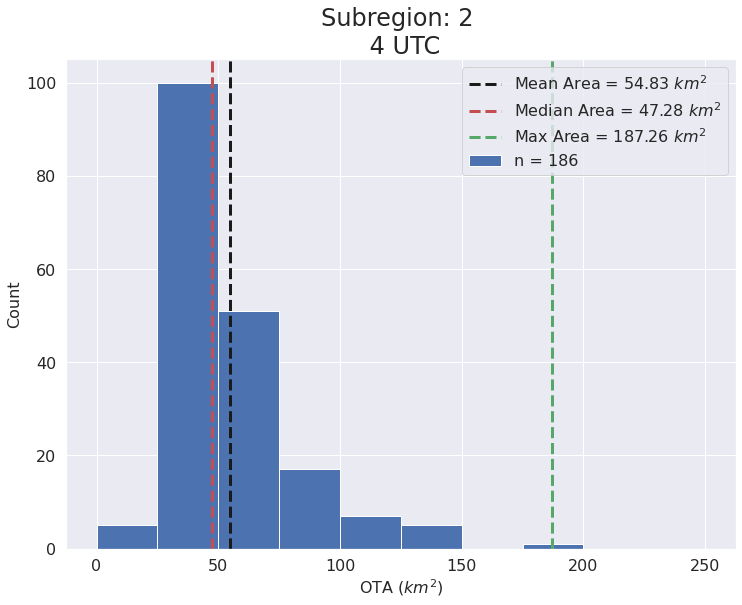

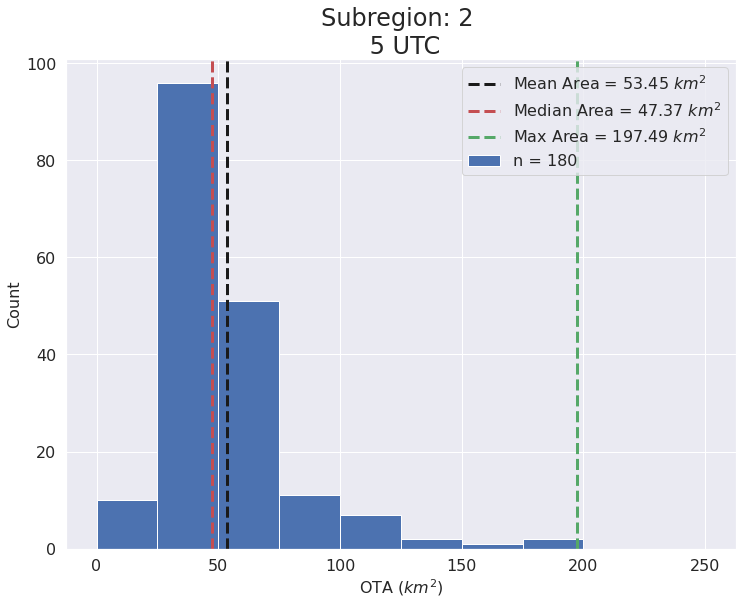

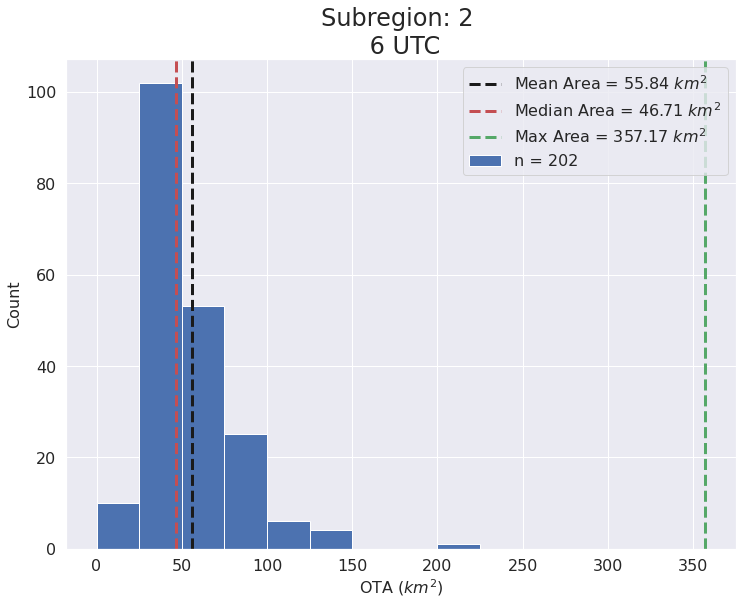

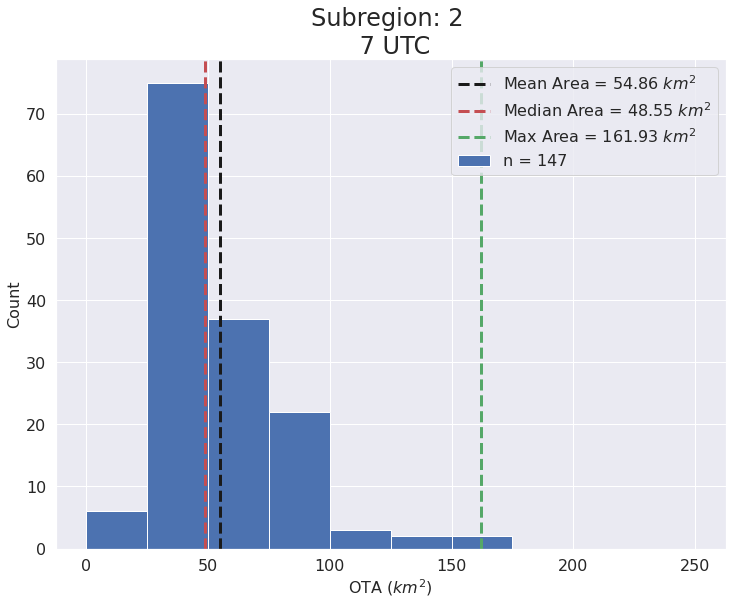

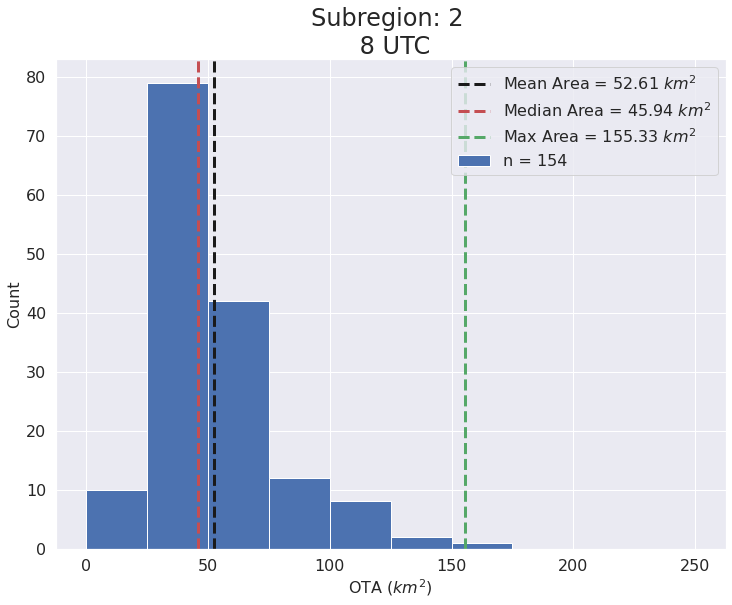

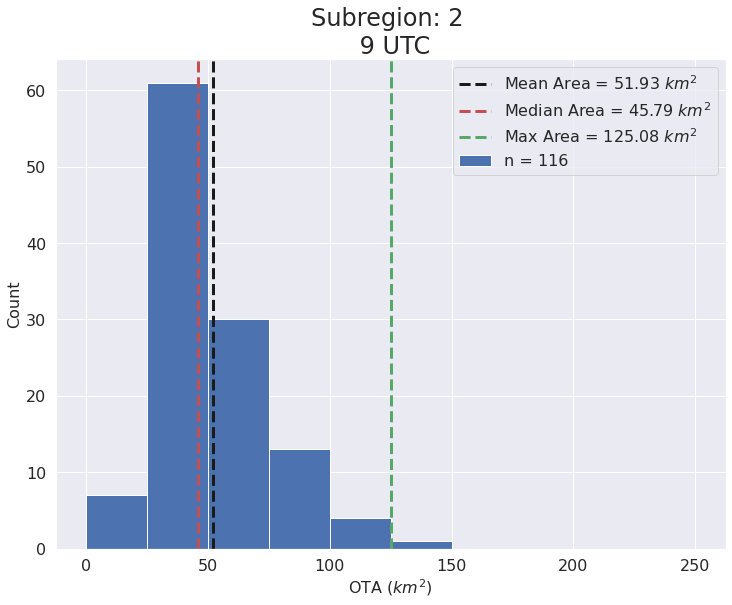

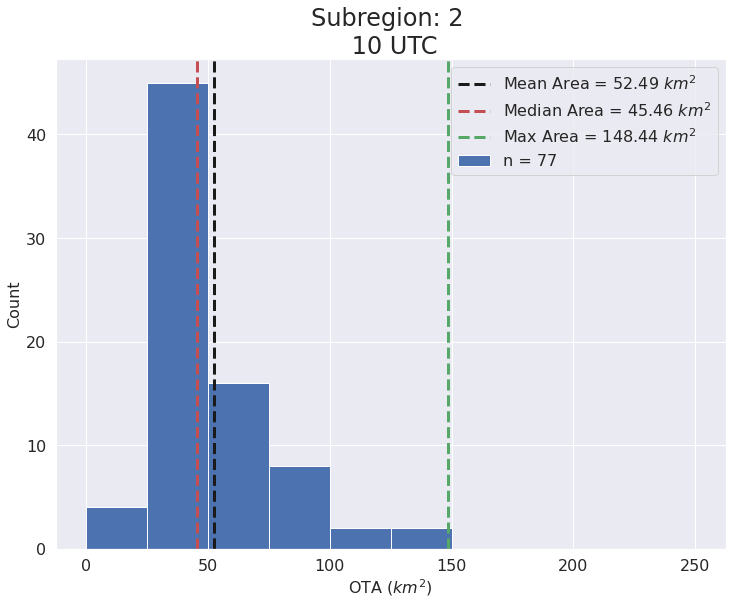

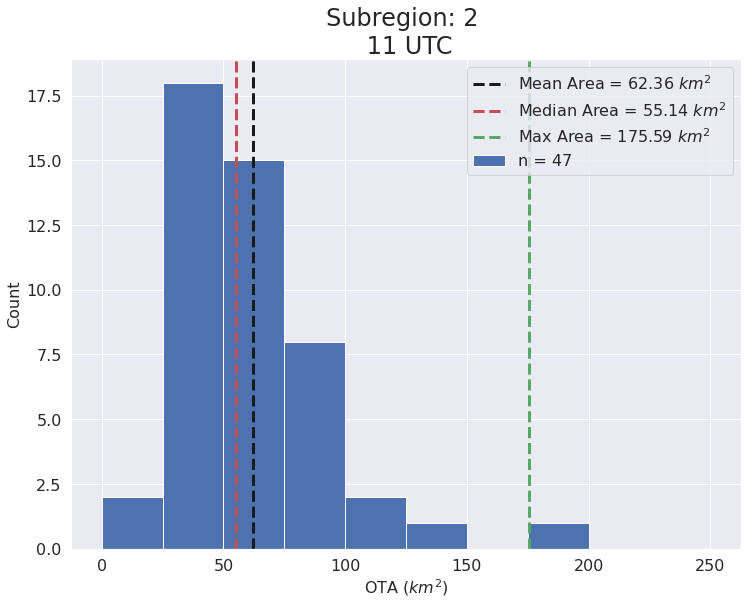

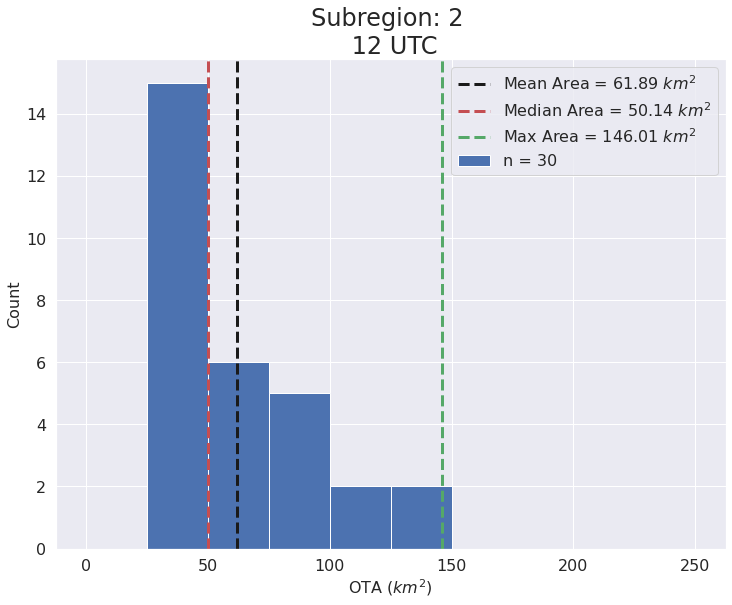

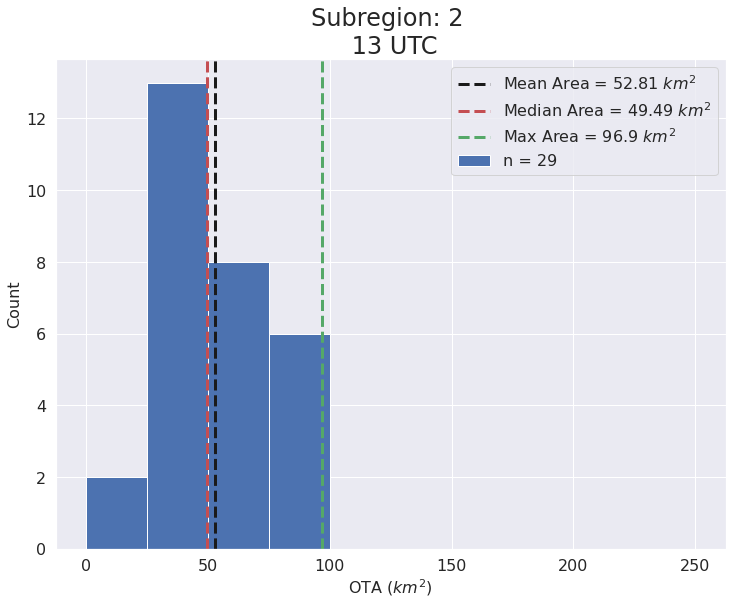

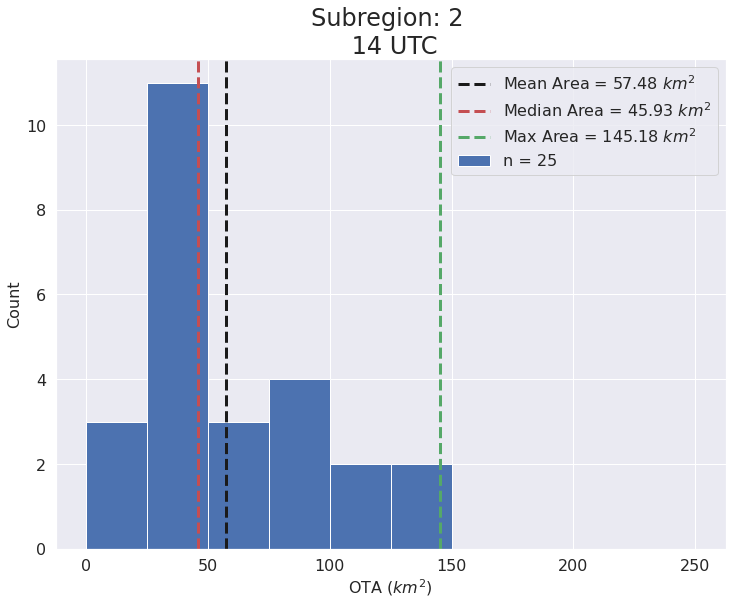

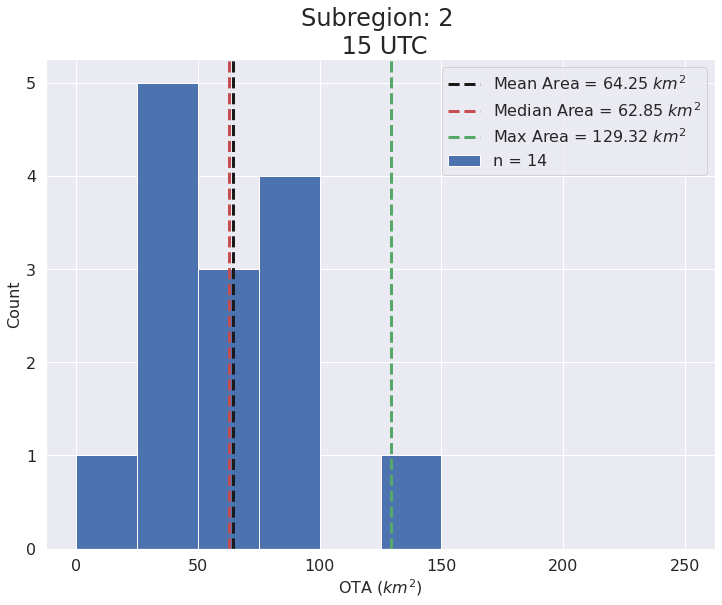

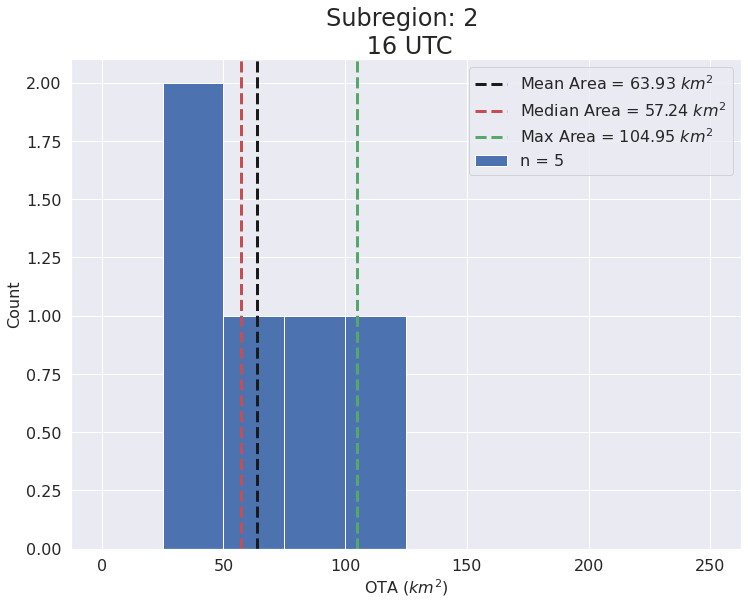

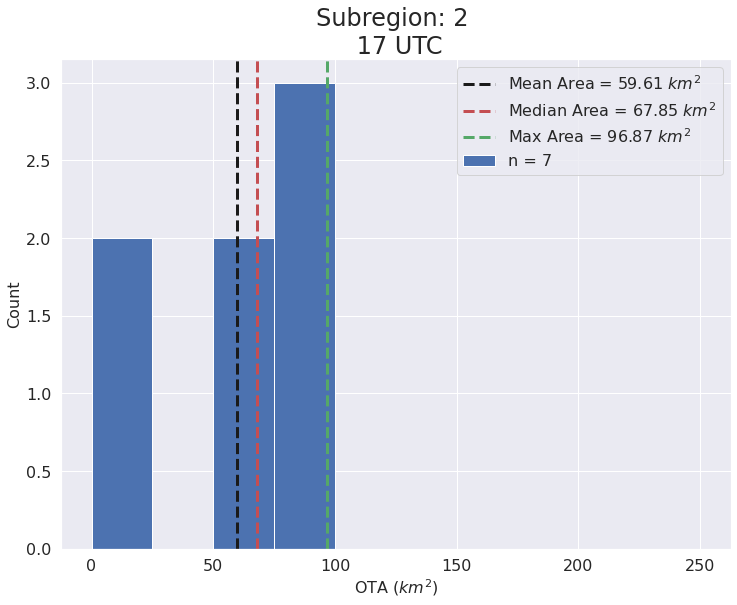

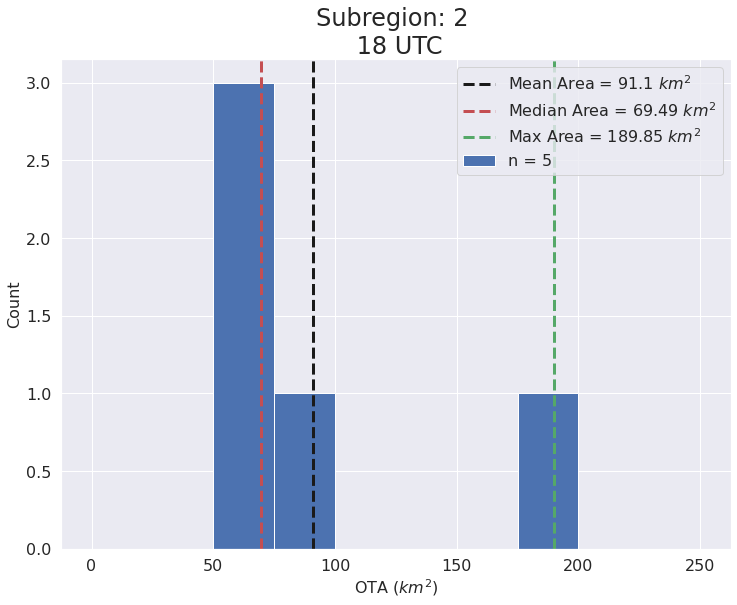

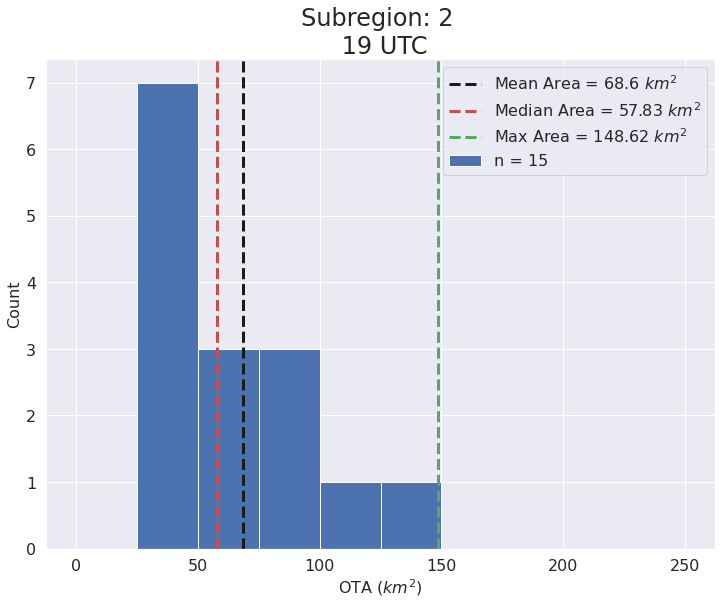

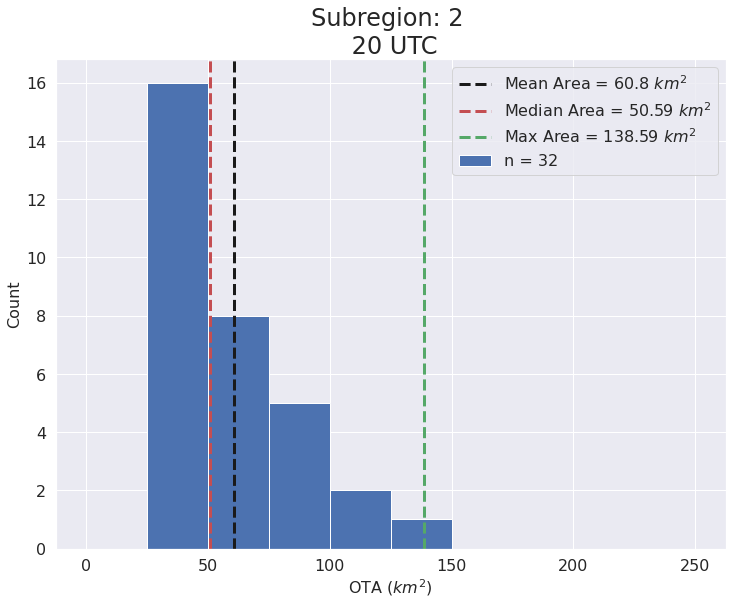

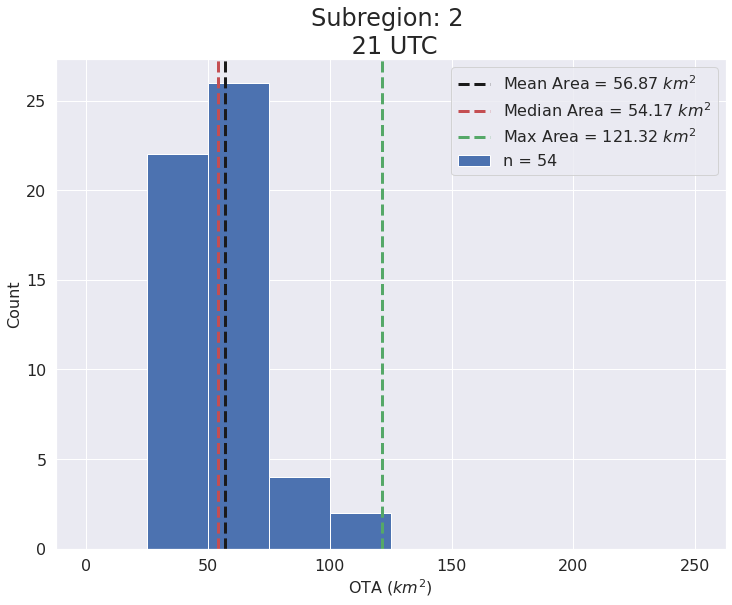

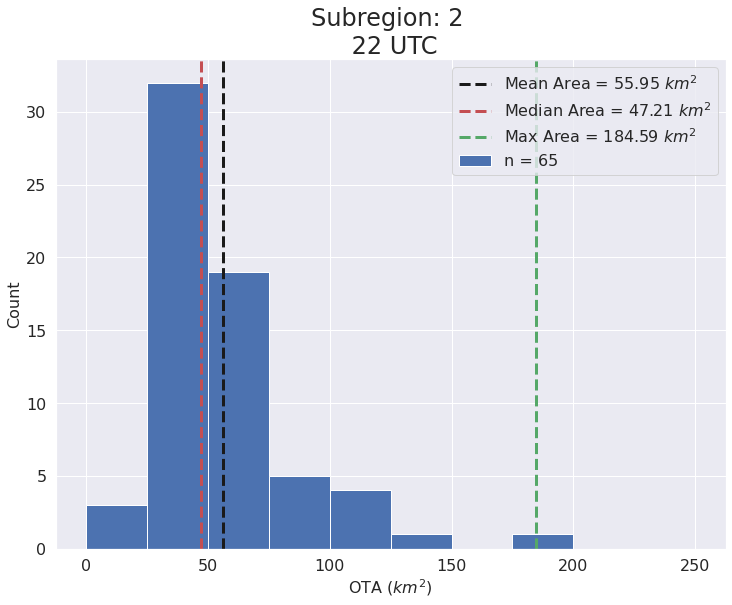

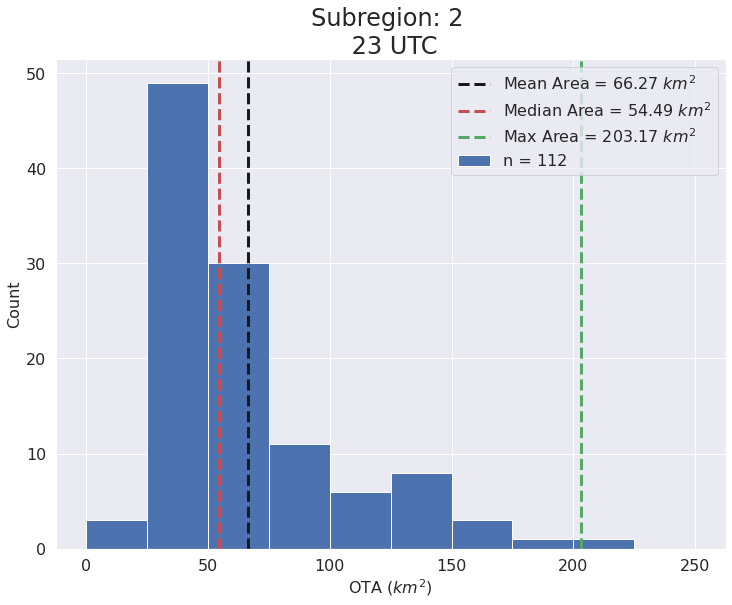

In [843]:
box_num = 2

for i in range(0, 24):
    plt.figure(figsize=(12,9))
    ax=plt.subplot(111)
    subset = sub_regions[(sub_regions.box_index == box_num) & (sub_regions.hour == i)]
    mean = round(np.mean(subset.area_polygon), 2)
    median = round(np.median(subset.area_polygon), 2)
    maxm = round(np.max(subset.area_polygon), 2)
    
    subset.area_polygon.plot.hist(ax=ax, bins = np.arange(0, 275, 25), label=f'n = {len(subset)}')
    plt.axvline(mean, linewidth=3, color='k', linestyle='--', label=f'Mean Area = {mean} $km^{2}$')
    plt.axvline(median, linewidth=3, color='r', linestyle='--', label=f'Median Area = {median} $km^{2}$')
    plt.axvline(maxm, linewidth=3, color='g', linestyle='--', label=f'Max Area = {maxm} $km^{2}$')
    plt.title(f'Subregion: {box_num} \n {i} UTC', fontsize=24)
    plt.xlabel('OTA ($km^{2}$)', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='upper right')
    plt.show()
    plt.close()
    

In [811]:
avg_boxes[avg_boxes.index == 19]

geometry    index_left  \
box_index                                                                    
19         POLYGON ((-90.00000 30.00000, -85.00000 30.000...  42264.132502   

           area_polygon  cloudtop_height  e_radial        lat   lat_corr  \
box_index                                                                  
19            53.935065        16.804654  4.391166  28.266257  27.886634   

                 lon   lon_corr      mintb  ...  area_circle_median  \
box_index                                   ...                       
19        -87.261666 -87.398533  194.07067  ...                 NaN   

           area_circle_polygon  ot_depth  max_radial   meanrad  otarea_circle  \
box_index                                                                       
19                         NaN  1.041069    6.422426  4.191254      59.343445   

              month       hour  mid_lon  mid_lat  
box_index                                         
19         7.610288  11.537802    -87.5     27.5  

[1 rows x 33 columns]

In [125]:
# Determine frequency of OTs by weighting by total number
count_boxes['freq'] = count_boxes['area_polygon'] / count_boxes.area_polygon.sum()

In [126]:
count_boxes.area_polygon.sum()

61964

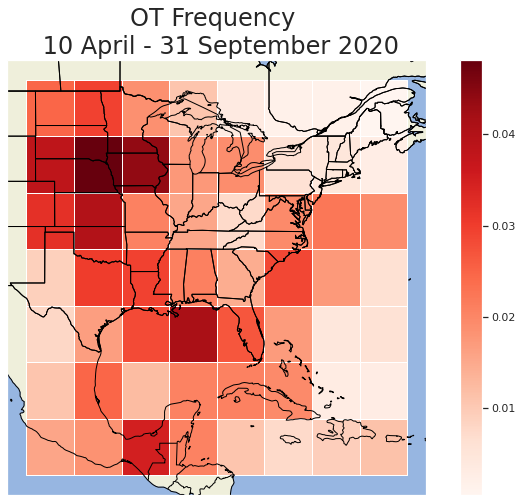

In [129]:
# Plot OT frequency
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Plot OT frequency, using Red colormap
count_boxes.plot(ax=ax, column='freq', legend=True, cmap='Reds')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)

plt.title('OT Frequency \n 10 April - 31 September 2020', fontsize=24);
plt.savefig('OT_freq_2020.png', dpi=300)

There are three primary regions of maximum OT frequency between April-September 2020:
1. Upper Midwest/Great Plains 
    1. This is likely due to Mesoscale Convective Systems (MCS)
    2. The Midwestern Derecho from 10 August 2020 (one of greatest frequency events, Nebraska --> Wisconsin
2. Northern Gulf of Mexico
    1. Tropical systems - there were several major hurricanes along the Gulf Coast in August/September 2020
3. Southern Mexico/Central America
    1. There are several mountains within this region, as well as adequate moisture which leads to frequent overshooting convection, which was identified as a popular region for OTs in Liu and Zipser (2005)

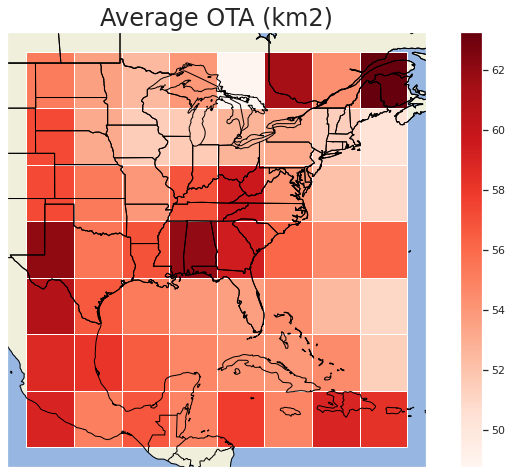

In [35]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111, projection=ccrs.PlateCarree())
avg_boxes.plot(ax=ax, column='area_polygon', legend=True, cmap='Reds')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)

plt.title('Average OTA (km2)', fontsize=24);

There is not a clear signal in regions with larger OTA. Area averages may have been impacted by the small bins near the fringes of the domain (western edge) and the northeast corner (Maine/Canada)

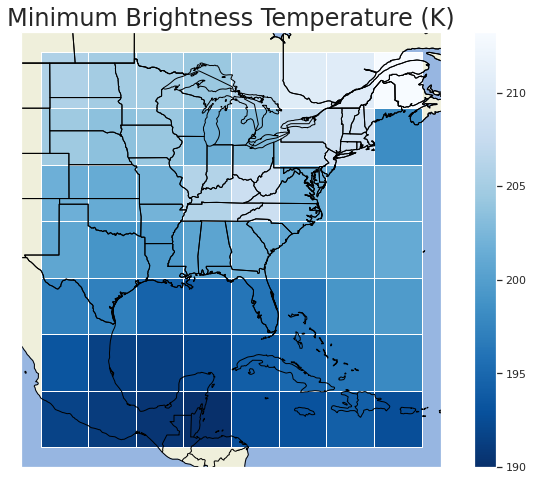

In [36]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111, projection=ccrs.PlateCarree())
avg_boxes.plot(ax=ax, column='mintb', legend=True, cmap='Blues_r')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)

plt.title('Minimum Brightness Temperature (K)', fontsize=24);

Minimum brightness temperature is strongly related to latitude - where tropical regions have lower minimum brightness temperature. This is because the tropopause is typically higher in the atmosphere near the tropics, and lower near the poles. Temperature generally decreases with height in the atmosphere, which explains why tropical regions would have cooler cloud top temperatures.

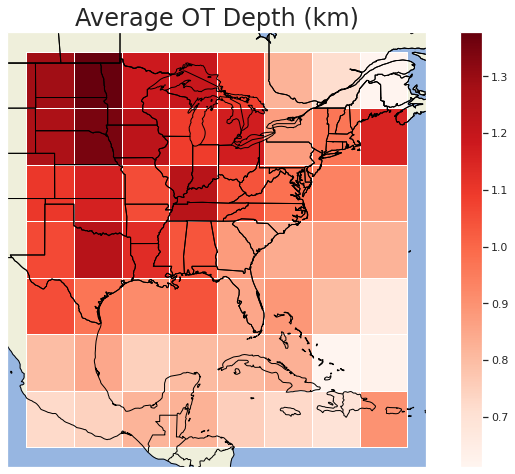

In [37]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111, projection=ccrs.PlateCarree())
avg_boxes.plot(ax=ax, column='ot_depth', legend=True, cmap='Reds')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)

plt.title('Average OT Depth (km)', fontsize=24);

Average OT depth appears to have a strong relationship between continental and oceanic regions. Peak OT depth (the distance between the OT height and tropopause) is at a maximum in the Great Plains and Midwest, while the Gulf Coast and Atlantic coastal regions, in addition to the Carribean have relatively lower average OT depth. The convection near the center of the continent is likely deeper and has updrafts that are capable of producing more intense OTs than oceanic regions. 